In [1]:
import requests
import json
import datetime as dt
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import ruptures as rpt
from fbprophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

warnings.filterwarnings('ignore')

# plotting options
%matplotlib inline
sns.set_style('darkgrid')
colors = sns.color_palette('deep', 8)
sns.set_palette(colors)
figsize1 = (17,8)
figsize2 = (17,4)
dpi=200
title_fontsize=16
ax_fontsize=12

/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:923: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
Using TensorFlow backend.


# Table of Contents
1. [Introduction](#introduction)
2. [Data](#data)
    - [EDA](#eda)
3. [Modeling](#modeling)
    - [ARIMA](#arima)
    - [ANN](#ann)

<a id='introduction'></a>
# 1. Introduction

- Research Question

- Approach
    - ARIMA
    - ANNs
    
**Evaluation**
- Models will predict last $n$ days of time series using a rolling forecast
- Forecasting:
    - Size of forecast window: model/performance dependent
    - Forecasts: one step at a time
    - After making a prediction, the observed value is available to make the next forecast
- Once all $n$ forecasts have been made, calculate RMSE against the test set

<a id='data'></a>
# 2. Data

## 2.1 Data Access & Preprocessing
- Functions to make API calls
- Get desired eth & exogenous variable data (for use in second part of analysis)
- Clean/combine into single df to draw from throughout analysis

In [ ]:
def cryptocompare_data(symbol,
                       comparison_symbol='USD',
                       all_data=True,
                       rows=1,
                       aggregate=1,
                       write_to=False):
    
    # symbol = symbol of desired coin
    # comparison symbol = symbol for currency to price with
    # to subset data, set all_data to false, then specificy with rows parameter
    # write_to = write dataframe to supported filetype: csv, json, pkl
    
    # api call
    url = 'https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(),
                    comparison_symbol.upper(),
                    rows,
                    aggregate)
    
    if all_data:
        url += '&allData=true'
    
    # store in dataframe
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['date'] = [dt.datetime.fromtimestamp(d) for d in df.time]
    df['date'] = df.date.dt.date
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
    df.drop('time', axis=1, inplace=True)
    df = df[['date', 'open', 'high', 'low', 'close', 'volumefrom', 'volumeto']]
    df.sort_values(by='date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # write to file option
    return_df=True
    if write_to is not False:
        return_df=False
        date = dt.datetime.today().strftime('%Y-%m-%d')
        filename = symbol.lower() + '_data_' + date + '.{}'.format(write_to)
        write_df(df, write_to, filename)
        
    if return_df is True:
        return df
    
def fred_data(series_id,
              api_key,
              file_type='json',
              frequency='d',
              raw=False,
              write_to=False):
    
    # series_id = string, symbol from fred
    # filetype options: xml, json, txt, xls
    # frequency options: d = daily, w = weekly, bw = biweekly
    # m = monthly, q = quarterly, sa = semiannual, a = annual
    # raw=True will skip the preprocessing and return the raw data
    # write_to=write dataframe to supported filetype: csv, json, pkl
    
    url = 'https://api.stlouisfed.org/fred/series/observations?series_id={}&api_key={}&file_type={}&frequency={}'\
                  .format(series_id,
                          api_key,
                          file_type,
                          frequency)
    
    response = requests.get(url)
    data = response.json()['observations']
    df = pd.DataFrame(data)
    
    if raw is False:
        df.drop(['realtime_end', 'realtime_start'], axis=1, inplace=True)
        df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
        df.rename(columns={'value':series_id.lower()}, inplace=True)
        
    return_df=True
    if write_to is not False:
        return_df=False
        date = dt.datetime.today().strftime('%Y-%m-%d')
        filename = series_id.lower() + '_data_' + date + '.{}'.format(write_to)
        write_df(df, write_to, filename)
        
    if return_df is True:
        return df

def write_df(df, write_to, filename):
    if write_to == 'csv':
        df.to_csv('{}'.format(filename), index=False)
    elif write_to == 'pkl':
        df.to_pickle('{}'.format(filename))
    elif write_to == 'json':
        df.to_json('{}'.format(filename), orient='split')
    else:
        print('function does not support writing to {}'.format(write_to))
        print('format filetype as shown (string in all lower case)')
        print('supported filetypes: csv, json, pkl')
        
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [ ]:
# get coin data
coins = ['ETH', 'BTC', 'XRP', 'EOS', 'LTC', 'XLM', 'XMR']

# create empty df for each coin
coins_d = {coin.lower(): pd.DataFrame() for coin in coins}

# populate coin dfs with respective coin data
for key, df in coins_d.items():
    coins_d[key] = cryptocompare_data(symbol=key)

# add coin names to columns & preview dfs
for key, df in coins_d.items():
    cols_orig = list(coins_d[key].columns)[1:]
    cols_new = ['date']
    for col in cols_orig:
        cols_new.append('{}_{}'.format(key, col))
    coins_d[key].columns = cols_new
    coins_d[key].set_index('date', inplace=True, drop=True)
    #display(coins_d[key].head(1))
    
# combine to single df
coins_df = pd.concat([df for key, df in coins_d.items()], axis=1)
display(coins_df.head(1))

# convert keys:values to variables = assignments
#locals().update(coins_d)

In [ ]:
# get fred data
fred_apikey = get_file_contents('fred_apikey')

indices = {
    'VIXCLS':'d', # cboe volatility index
    'TWEXB':'w', # trade weighted usd index
    'EFFR':'d' # effective federal funds rate
    }

# create empty df for each index
indices_d = {index: pd.DataFrame() for index in indices}

# populate dfs with index data
for key in set(indices.keys()) and set(indices_d.keys()):
    indices_d[key] = fred_data(series_id=key,
                               api_key=fred_apikey,
                               frequency = indices[key])
    indices_d[key].set_index('date', inplace=True, drop=True)

# lowercase dict keys, preview dfs
indices_d =  {key.lower(): value for key, value in indices_d.items()}

#for key, df in indices_d.items():
#    display(df.head(1))

# combine to single df    
fred_df = pd.concat([df for key, df in indices_d.items()], axis=1)
display(fred_df.head(1))

# convert to variables = assignments
#locals().update(indices_d)

In [ ]:
# combine data into single df
df_alldata = pd.concat([coins_df, fred_df], axis=1)

# replace '.' with nan so ffill will catch everything
# '.' denotes a holiday
df_alldata.replace('.', np.nan, inplace=True)

# ffill values for weekends skipped by traditional indices
df_alldata.ffill(inplace=True)

# start dataframe at beginning of ethereum
df = df_alldata[df_alldata.eth_close.isnull().sum():]
display(df.head(3))

# check missingness
for col in df.columns:
    if df['{}'.format(col)].isnull().any() == True:
        print(col)

In [ ]:
df.to_json('df.json', orient='split')

**Note**: EOS & XLM currencies started after ETH (hence their missing values). Will address this later when dealing with exogenous variables

<a id='eda'></a>
## 2.2 Time Series EDA

In [27]:
raw = pd.read_json('df.json', orient='split')
ts = pd.DataFrame(raw.eth_close).copy()
ts.head(3)

,eth_close
2015-08-06,3.0
2015-08-07,1.2
2015-08-08,1.2


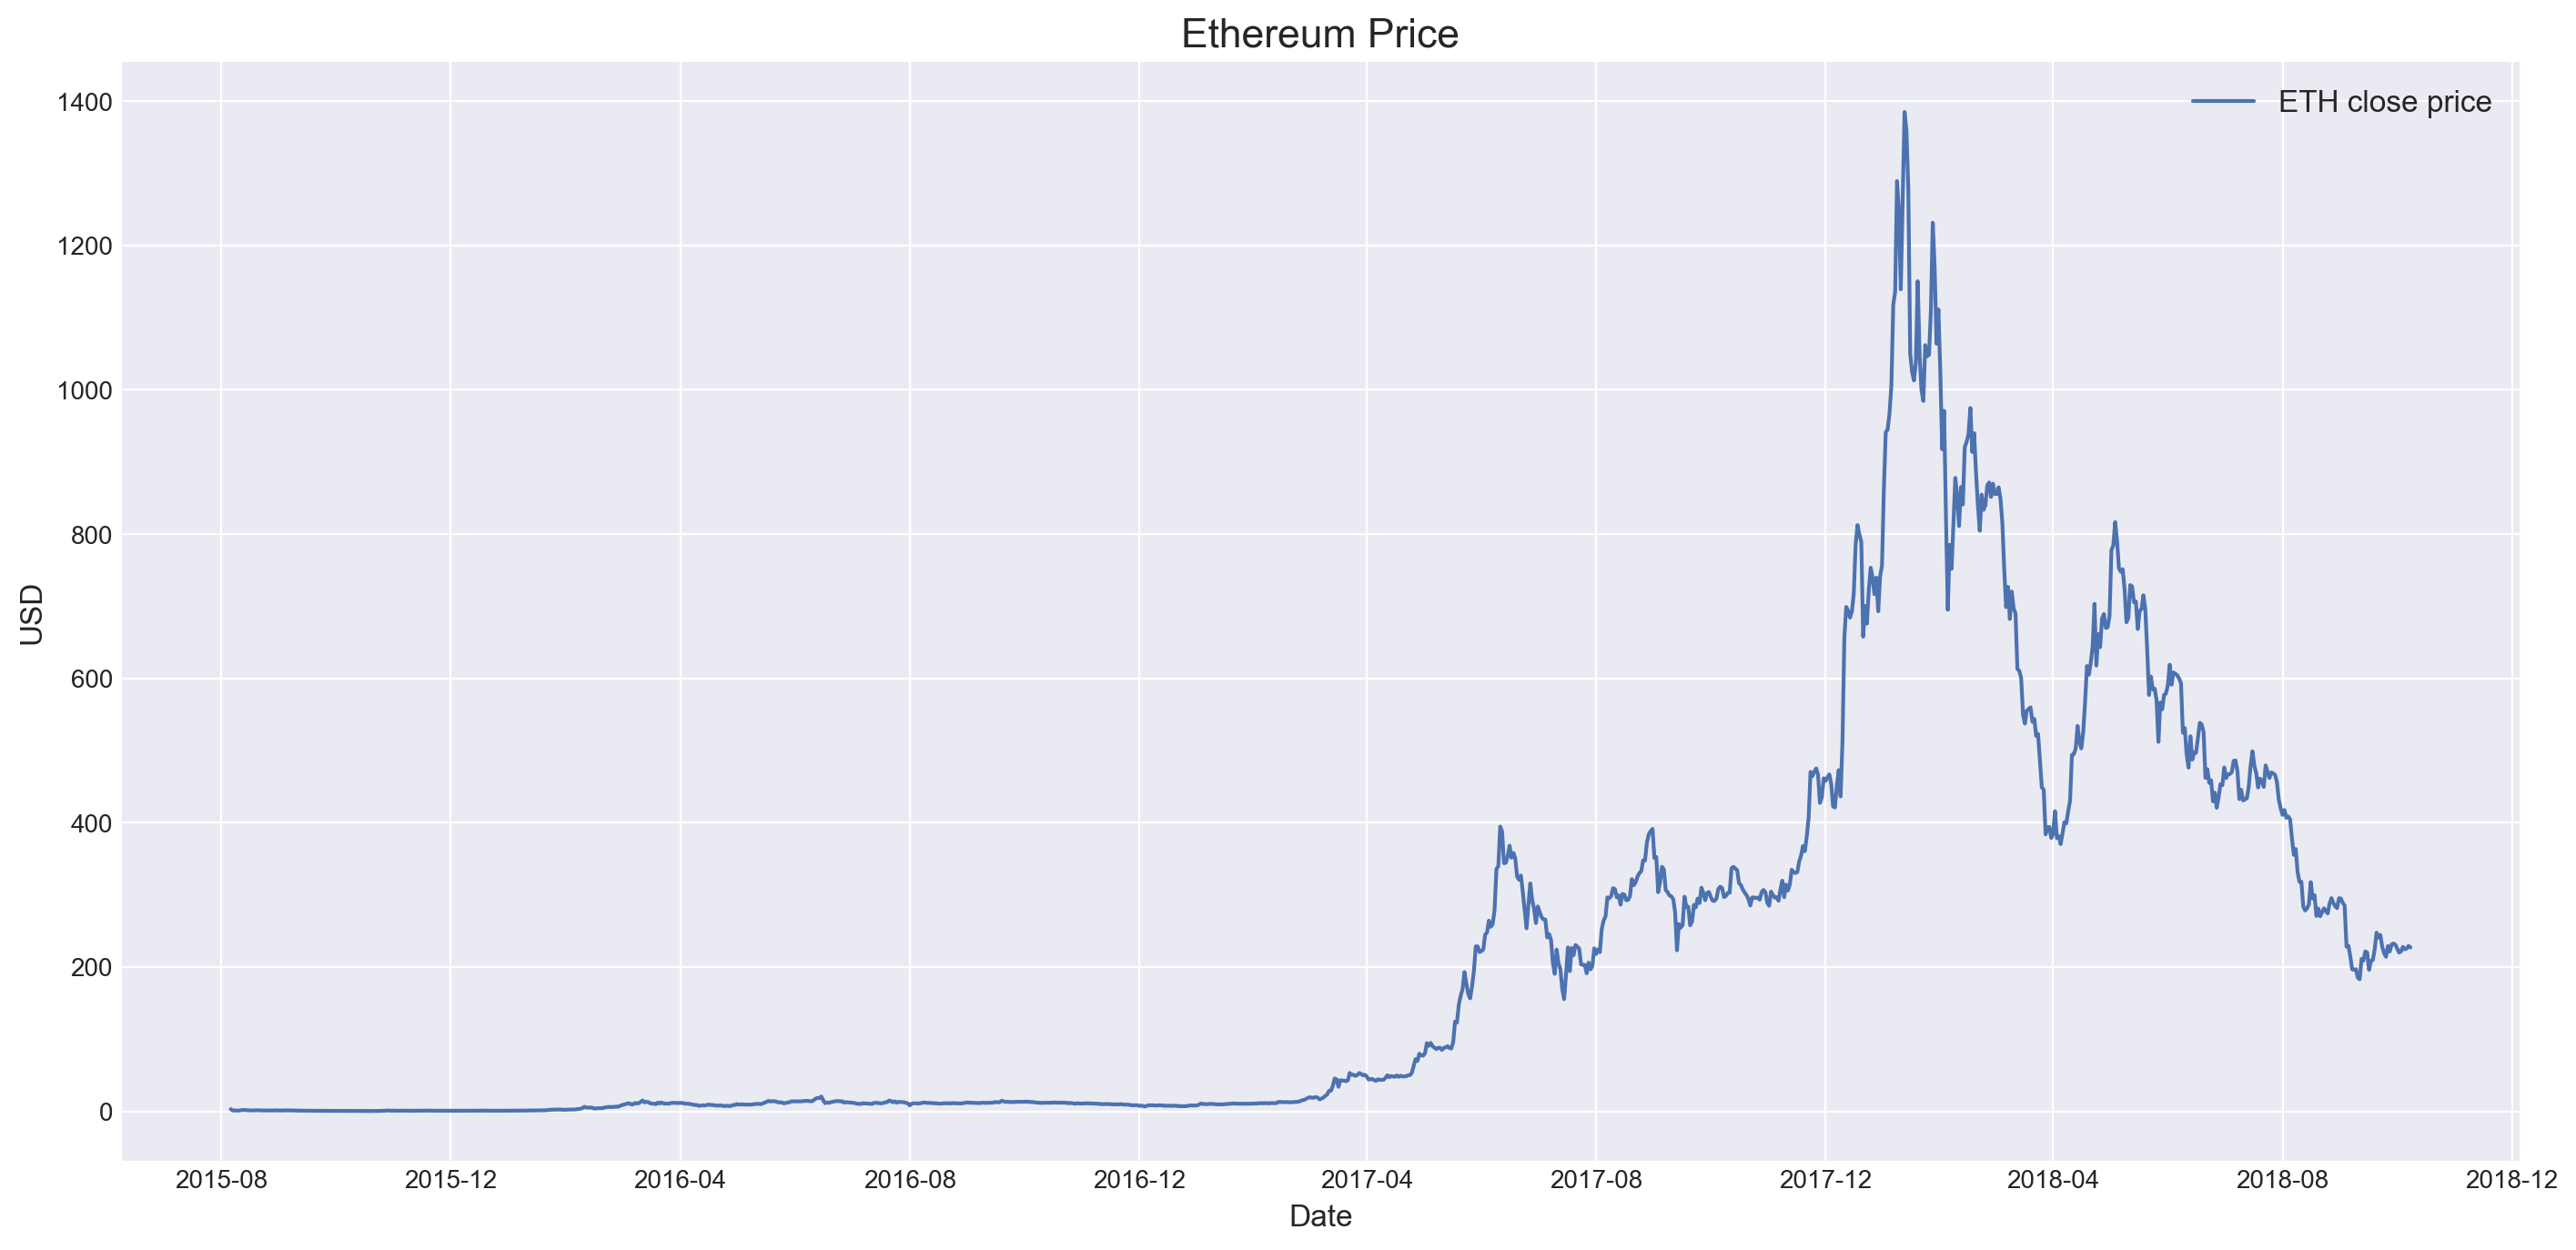

adf: -1.8276176517546157
pval: 0.36683903920126115
critical vals {'1%': -3.4361194876415078, '5%': -2.8640875863904105, '10%': -2.5681264020345664}


In [28]:
fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
ax.plot(
    ts.index.values,
    ts.eth_close,
    label="ETH close price",
    color=colors[0]
)
ax.set_title("Ethereum Price", size=title_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
ax.legend(prop={'size':ax_fontsize})
plt.show()

print("adf: {0}\npval: {1}\ncritical vals {2}".format(
    adfuller(ts.eth_close)[0],
    adfuller(ts.eth_close)[1],
    adfuller(ts.eth_close)[4]))

**Interpretation:**
- Data displays trend(s), ADF test confirms non-stationarity
- Data does not appear to have a seasonality component
- Graph indicates presence of structural breaks

**To do:**
- Perform change point analysis
- Get stationary time series

### 2.2.1 Change point analysis
- Potential side aspect: compare change point analysis by fbprophet to ruptures
    - FBProphet is automatic but designed for seasonal data which this is not
    - Ruptures requires more setup but is more flexible, may result in better analysis if set up properly

In [29]:
# estimate changepoints with ruptures
cpts_ruptures = rpt.Pelt(model='rbf').fit_predict(ts, pen=10)

print("Predicted by PELT:\n{}".format(cpts_ruptures))

# do the same with fbprophet
ts_prophet = ts.copy().reset_index()
ts_prophet.columns = (['ds', 'y'])

m = Prophet().fit(ts_prophet)
#print(m.changepoints.index)

# populate df with changepoints
cpts_df = pd.DataFrame(
    {'index_locator':m.changepoints.index,
     'cpts_prophet':m.changepoints.values,
     'delta':m.params['delta'].mean(0)})
print("\nPredicted by Prophet:\n{}".format(list(m.changepoints.index)))

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predicted by PELT:
[655, 835, 860, 880, 910, 950, 985, 1040, 1100, 1160]

Predicted by Prophet:
[37, 74, 111, 148, 185, 222, 260, 297, 334, 371, 408, 445, 482, 519, 556, 593, 630, 667, 705, 742, 779, 816, 853, 890, 927]


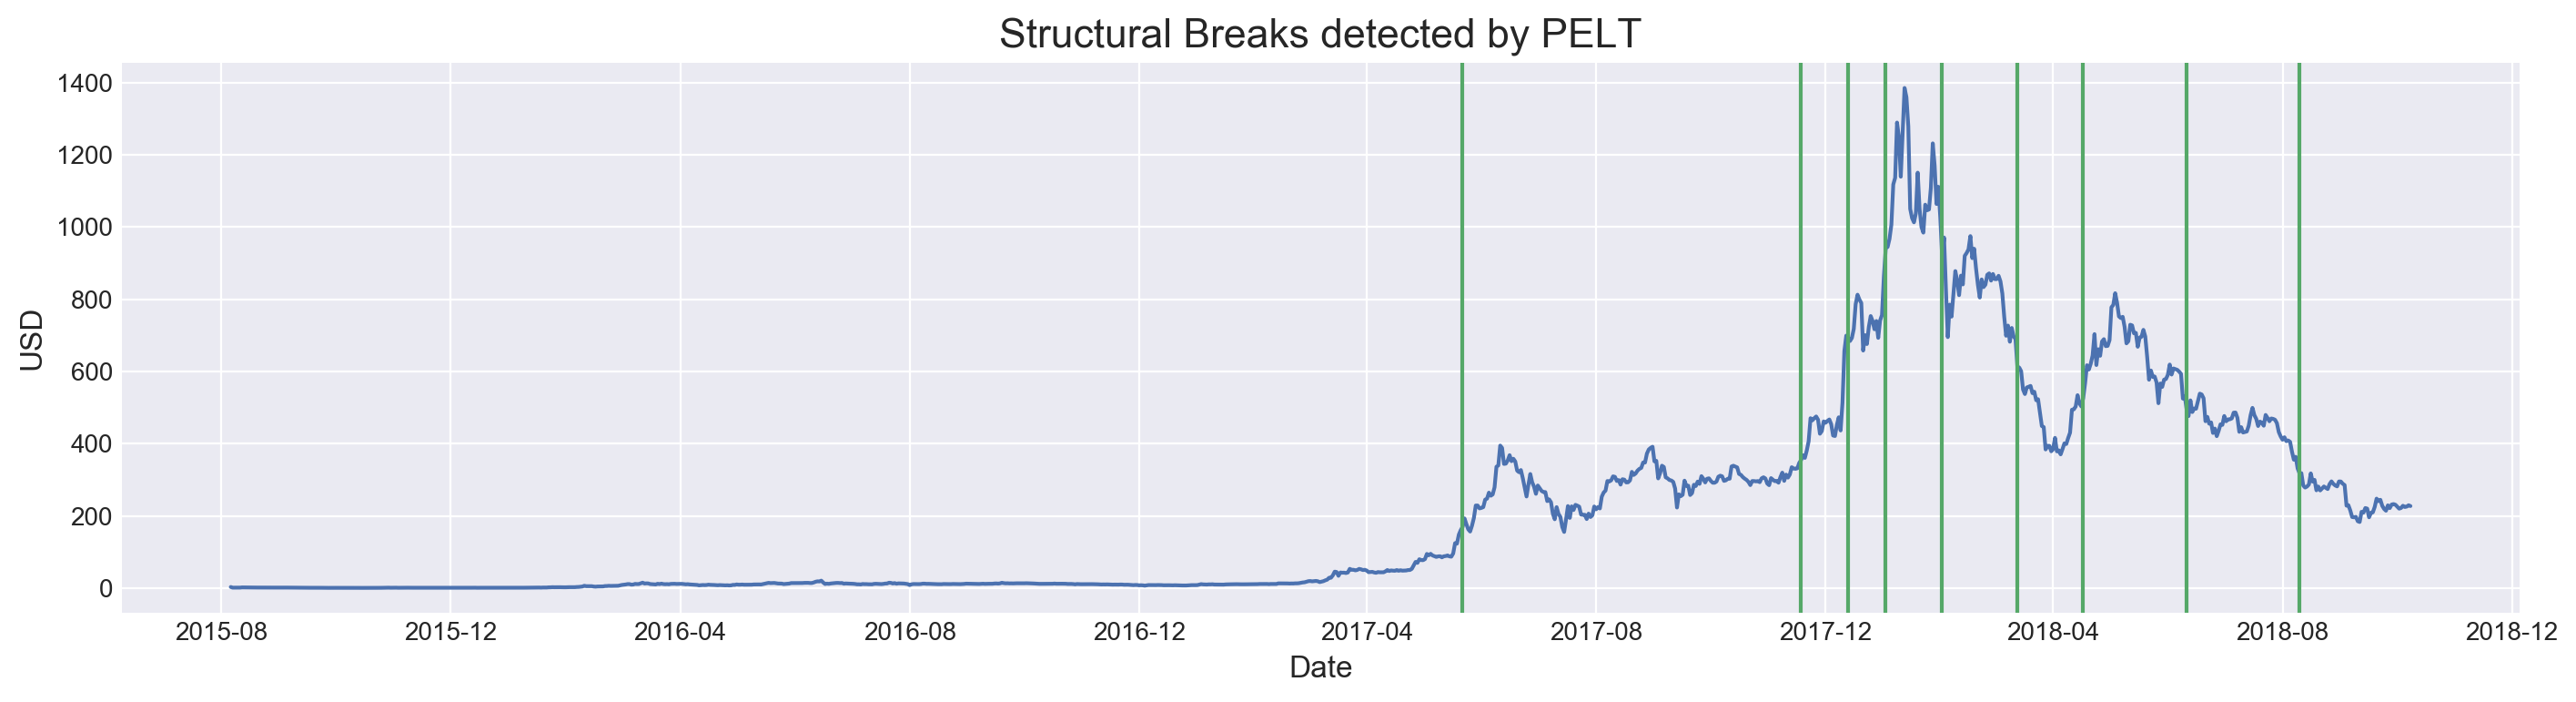

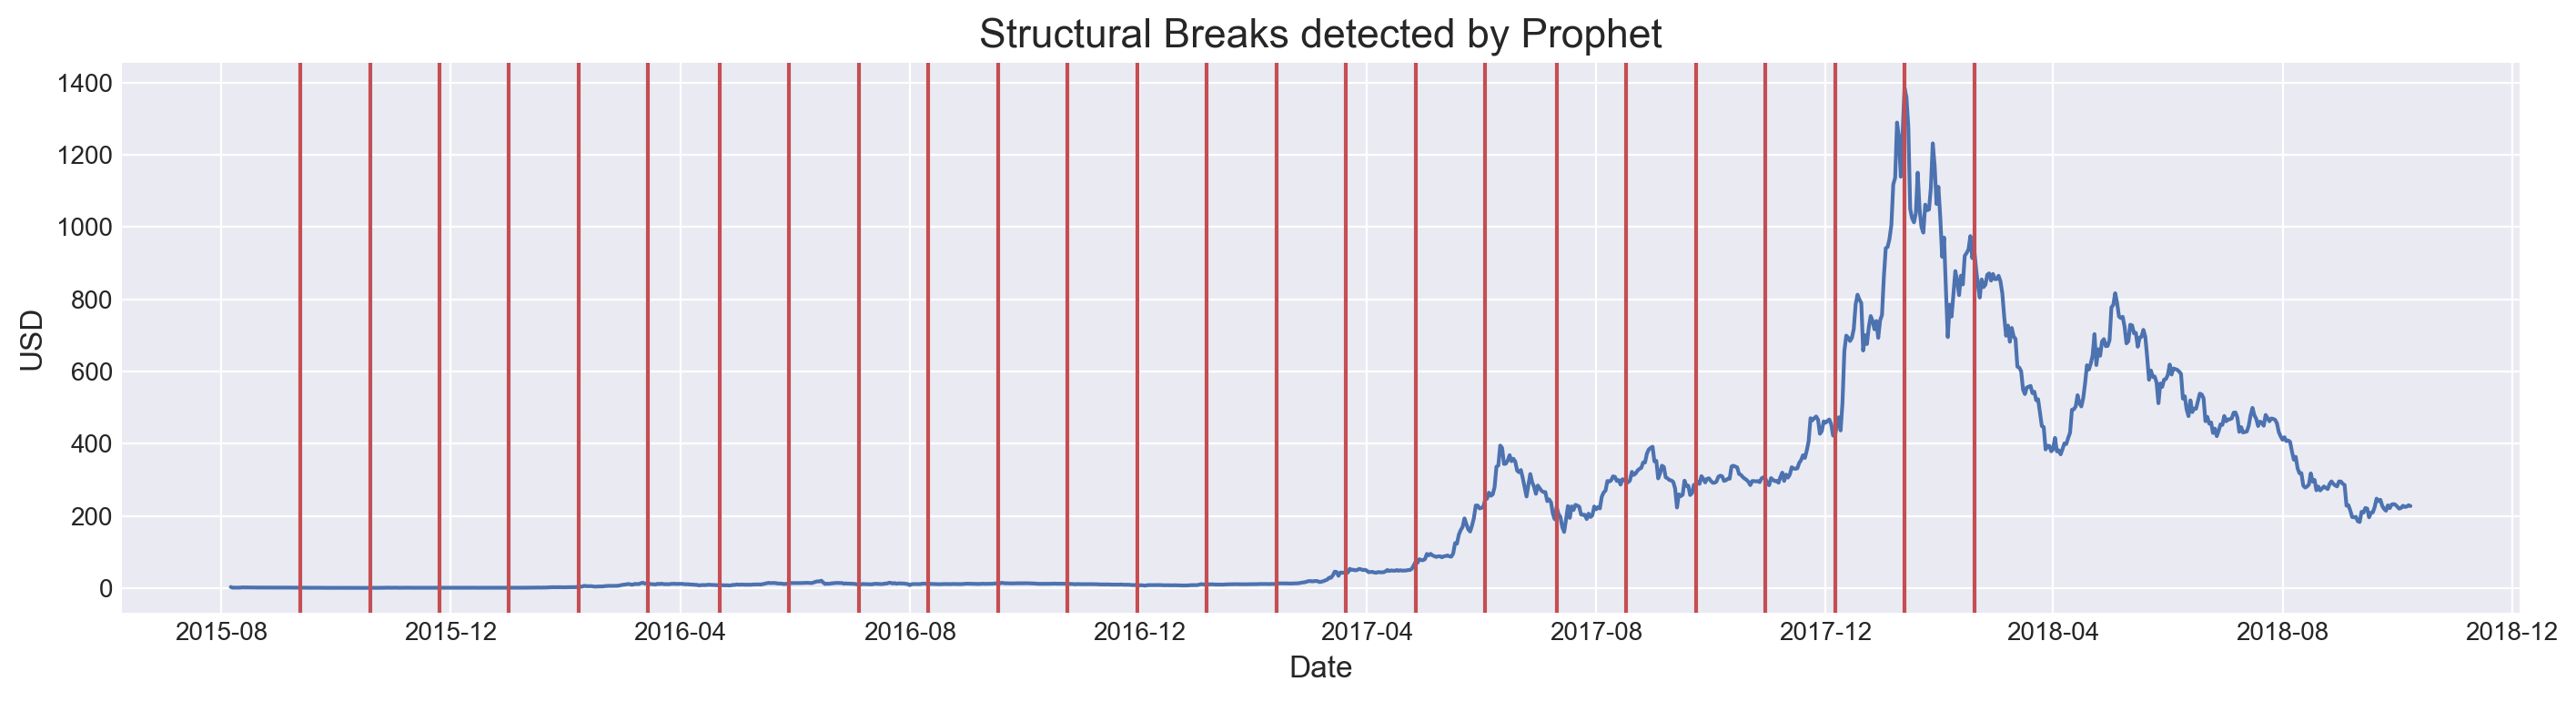

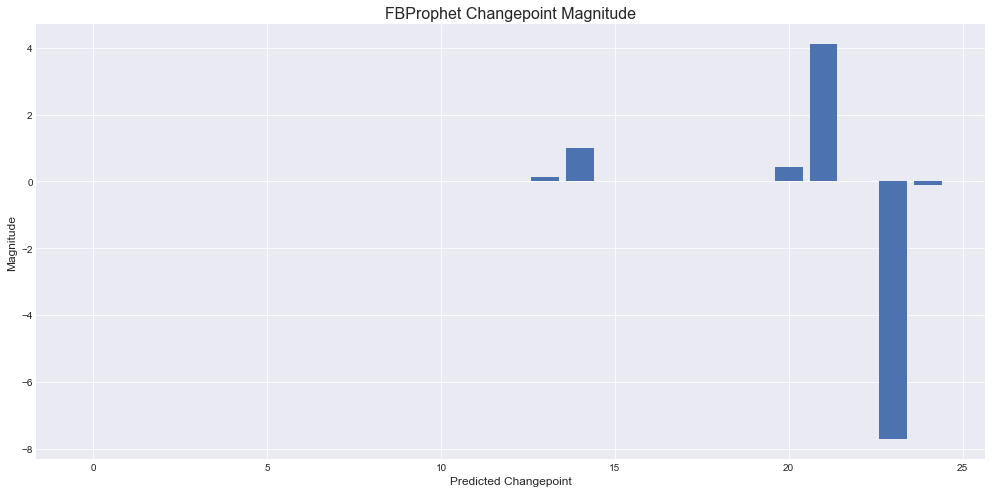

In [30]:
# plot PELT
fig, ax = plt.subplots(figsize=figsize2, dpi=200)
plt.plot(
    ts.index.values,
    ts.eth_close,
    color=colors[0]
)
for pt in cpts_ruptures[:-1]:
    plt.axvline(
        x=ts.index.values[pt],
        color=colors[1],
        linewidth=1.5,
    )
ax.set_title("Structural Breaks detected by PELT", size=title_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
plt.show()

# plot Prophet
fig, ax = plt.subplots(figsize=figsize2, dpi=200)
plt.plot(
    ts.index.values,
    ts.eth_close,
    color=colors[0]
)
for pt in list(cpts_df.index_locator):
    plt.axvline(
        x=ts.index.values[pt],
        color=colors[2],
        linewidth=1.5,
    )
ax.set_title("Structural Breaks detected by Prophet", size=title_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
plt.show()

# plot magnitudes
### FIX THIS CHART X-AXIS ###
### MAKE X LINE UP WITH ABOVE CHART ###
fig, ax = plt.subplots(figsize=figsize1)
ax.bar(range(len(cpts_df.delta)), cpts_df.delta)
ax.set_title('FBProphet Changepoint Magnitude', size=title_fontsize)
ax.set_ylabel("Magnitude", size=ax_fontsize)
ax.set_xlabel("Predicted Changepoint", size=ax_fontsize)
plt.show()

In [46]:
# extract significant potential changepoints

delta_mean = np.mean(abs(cpts_df.delta))
cpts_prophet = []

for i, row in cpts_df.iterrows():
    if cpts_df.delta[i] >= delta_mean:
        cpts_prophet.append(row.index_locator)
    elif cpts_df.delta[i] <= -delta_mean:
        cpts_prophet.append(row.index_locator)

print(cpts_prophet)
print(cpts_ruptures)

[556, 816, 890]
[655, 835, 860, 880, 910, 950, 985, 1040, 1100, 1160]


In [50]:
cpts_pos = []
cpts_neg = []
for i, row in cpts_df.iterrows():
    if cpts_df.delta[i] > 0:
        cpts_pos.append(cpts_df.delta[i])
    if cpts_df.delta[i] < 0:
        cpts_neg.append(cpts_df.delta[i])

cpts_prophet = []        
mean_pos = np.mean(cpts_pos)
mean_neg = np.mean(cpts_neg)

for i, row in cpts_df.iterrows():
    if cpts_df.delta[i] >= mean_pos:
        cpts_prophet.append(row.index_locator)
    elif cpts_df.delta[i] <= mean_neg:
        cpts_prophet.append(row.index_locator)
        
print(cpts_prophet)
print(cpts_ruptures)

[556, 779, 816, 890]
[655, 835, 860, 880, 910, 950, 985, 1040, 1100, 1160]


In [51]:
break_points = cpts_prophet[:1] + cpts_ruptures[:-1]
print("break points:\n{}".format(break_points))

break points:
[556, 655, 835, 860, 880, 910, 950, 985, 1040, 1100]


### 2.2.2 Window Size Selection

In [52]:
pt_diffs = []

for i, point in enumerate(break_points[:-1]):
    pt_diffs.append(break_points[i+1] - point)
    
pt_diffs.sort()
print("pt_diffs: {}".format(pt_diffs))
print("pt_diffs mean = {:.2f}".format(np.mean(pt_diffs)))
print("pt_diffs mode = {}".format(max(set(pt_diffs), key=pt_diffs.count)))

pt_diffs: [20, 25, 30, 35, 40, 55, 60, 99, 180]
pt_diffs mean = 60.44
pt_diffs mode = 35


In [53]:
window = 35

### 2.2.3 Stationarity

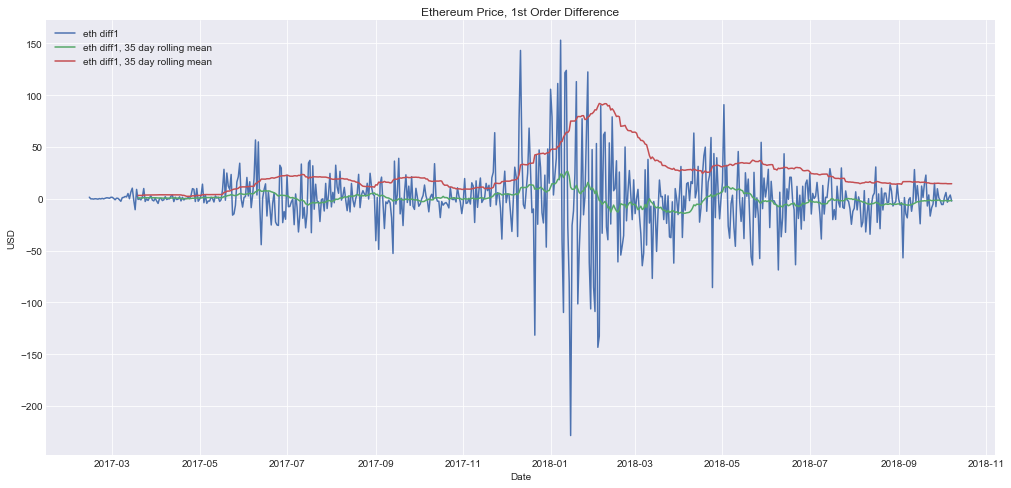

1st order differenced ADF test results

price:
adf -3.7218
pval 0.0038163747578120496
critical vals {'1%': -3.441616425652826, '5%': -2.866510292004876, '10%': -2.5694170294713863}


In [54]:
# reset time series using first significant changepoint
ts = ts[break_points[0]:]
# first order difference
ts['diff1'] = diff(ts.eth_close, k_diff=1)

plt.figure(figsize=(figsize1))
plt.plot(
    ts.index.values[1:],
    ts.diff1[1:],
    label='eth diff1',
    color=colors[0]
)
plt.plot(
    ts.index.values[1:],
    ts.diff1[1:].rolling(window).mean(),
    label='eth diff1, {} day rolling mean'.format(window),
    color=colors[1]
)
plt.plot(
    ts.index.values[1:],
    ts.diff1[1:].rolling(window).std(),
    label='eth diff1, {} day rolling mean'.format(window),
    color=colors[2]
)
plt.title('Ethereum Price, 1st Order Difference')
plt.ylabel('USD')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

# ADF Test
adf_diff1 = adfuller(ts.diff1.dropna())

print('1st order differenced ADF test results')
print('\nprice:\nadf {:.4f}\npval {}\ncritical vals {}'.format(
    adf_diff1[0], adf_diff1[1], adf_diff1[4]))

<a id='modeling'></a>
# 3. Modeling & Forecasting Time Series

<a id='arima'></a>
## 3.1 ARIMA
### 3.1.1 ACF/PACF

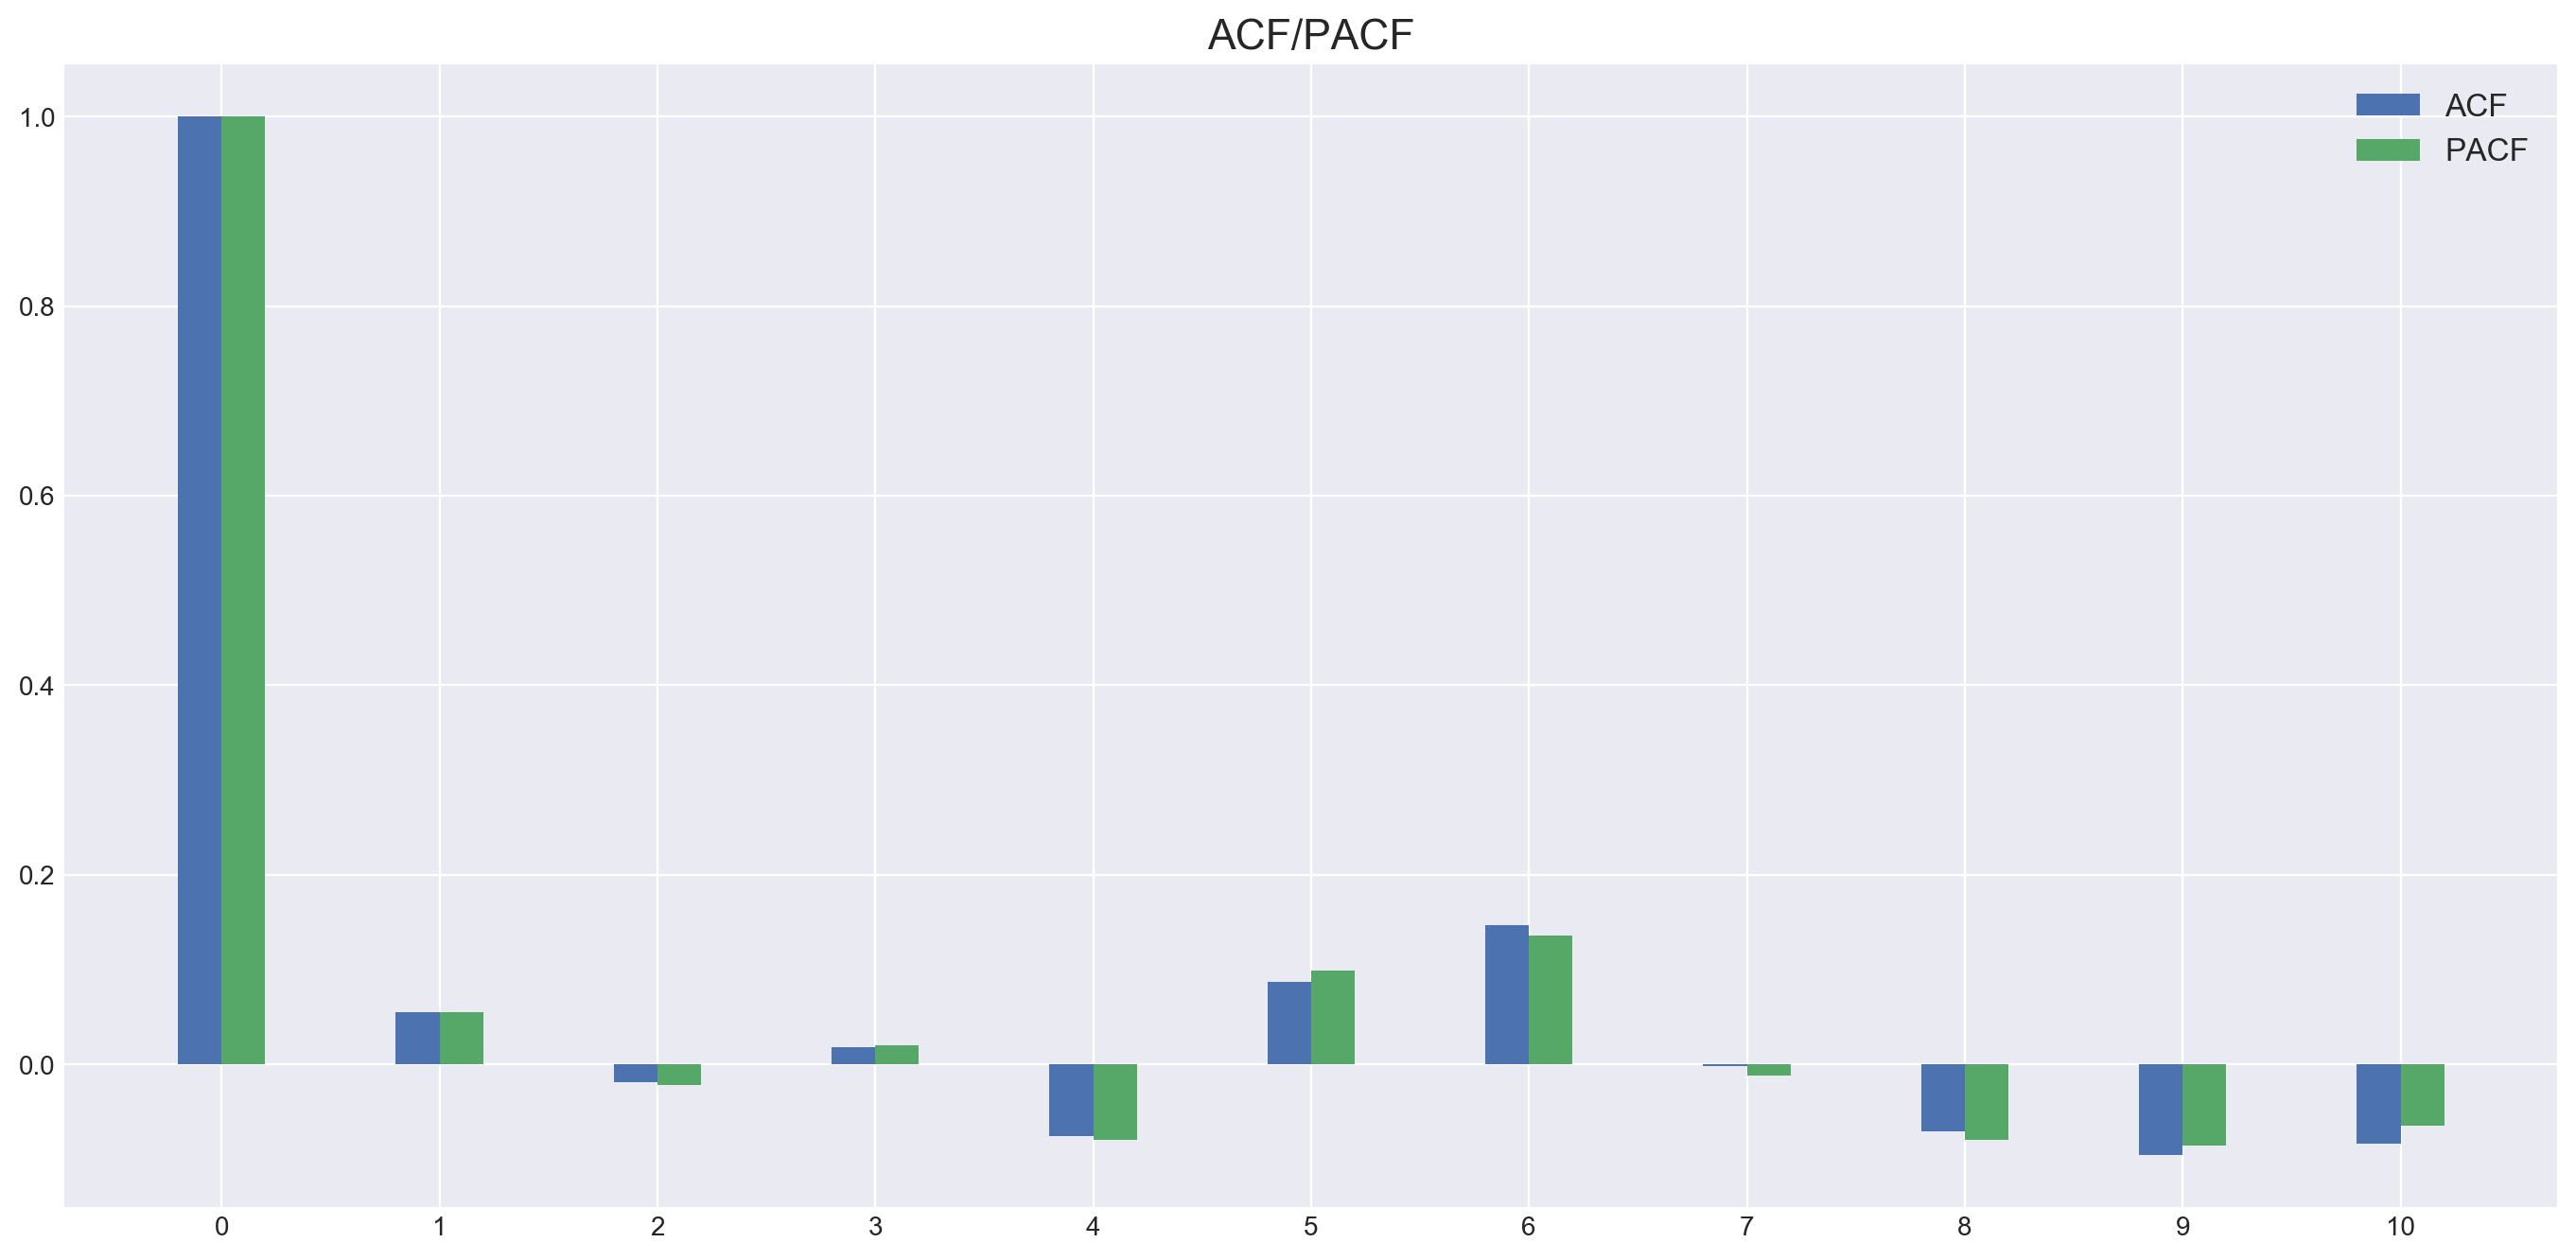

In [55]:
acf_diff1 = acf(ts.diff1.dropna(), nlags=10)
pacf_diff1 = pacf(ts.diff1.dropna(), nlags=10)

fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
ax.bar(
    [n-.1 for n in range(len(acf_diff1))],
    acf_diff1,
    label="ACF",
    width=.2,
    color=colors[0],
    align='center'
)
ax.bar(
    [n+.1 for n in range(len(acf_diff1))],
    pacf_diff1,
    label="PACF",
    width=.2,
    color=colors[1],
    align='center'
)
ax.legend(prop={'size':ax_fontsize})
ax.set_title("ACF/PACF", size=title_fontsize)
ax.set(xticks= [n for n in range(len(acf_diff1))])

plt.show()

**Interpretation**:
- ACF: perhaps a small MA component
- PACF perhaps a small AR component

### 3.1.2 ARIMA Modeling & Forecasting
- Build the following:
    - ARIMA(0,1,0): d=1, no AR/MA component
    - ARIMA(1,1,0): ar=1, d=1, no MA component
    - ARIMA(0,1,1): d=1, ma=1, no AR component
- Evaluation:
    - AIC/BIC
    - RMSE

In [56]:
def arima_forecast(endog, order, window, n_steps=1, exog=None):
    start = 0
    stop = window
    aic = []
    preds = []
    
    for n in range(len(endog) - window):
        if exog is None:
            # sample data and train model
            model = ARIMA(
                endog=endog[start:stop],
                order=order
            ).fit()
            # make and store forecasts
            yhat = model.forecast(steps=n_steps)
        
        if exog is not None:
            # sample data and train model
            model = ARIMA(
                endog=endog[start:stop],
                exog=exog[start:stop],
                order=order
            ).fit(trend='nc')
            # make and store forecasts
            yhat = model.forecast(
                steps=n_steps,
                exog=exog[stop:stop+1]
            )
            
        # store results and step forward
        aic.append(model.aic)
        preds.append(yhat[0][0])
        start += 1
        stop += 1
   
    results = np.array([preds, aic])
    return results

def rmse(observed, predicted):
    rmse = np.sqrt(mean_squared_error(observed[-len(predicted):], predicted))
    return rmse

In [57]:
# set required variables
window = 35
endog = ts.eth_close
exog = ts.loc[:, ~ts.columns.isin(['eth_close', 'diff1'])]

In [58]:
# time series only
# instantiate, train, & forecast
d1_fc = arima_forecast(
    endog=endog,
    order=(0,1,0),
    window=window
)
ar1_fc = arima_forecast(
    endog=endog,
    order=(1,1,0),
    window=window
)
ma1_fc = arima_forecast(
    endog=endog,
    order=(0,1,1),
    window=window
)

# evaluate results
forecasts = {
    'd1_fc': d1_fc,
    'ar1_fc': ar1_fc,
    'ma1_fc': ma1_fc
}

arima_preds_rmse = {}
for name, model in forecasts.items():
    # calculate error
    rmse_pred = rmse(ts.eth_close[window:], model[0])
    arima_preds_rmse.update({name:rmse_pred})

arima_summary_df = pd.DataFrame.from_dict(arima_preds_rmse, orient='index', columns=['rmse'])
print("ARIMA RMSE Results")
display(arima_summary_df)

# get best model    
best_model = min(arima_preds_rmse, key=arima_preds_rmse.get)
print("best model: {}\nrmse: {:.6f}".format(best_model, arima_preds_rmse[best_model]))

ARIMA RMSE Results


,rmse
d1_fc,33.034649
ar1_fc,33.867252
ma1_fc,34.083564


best model: d1_fc
rmse: 33.034649


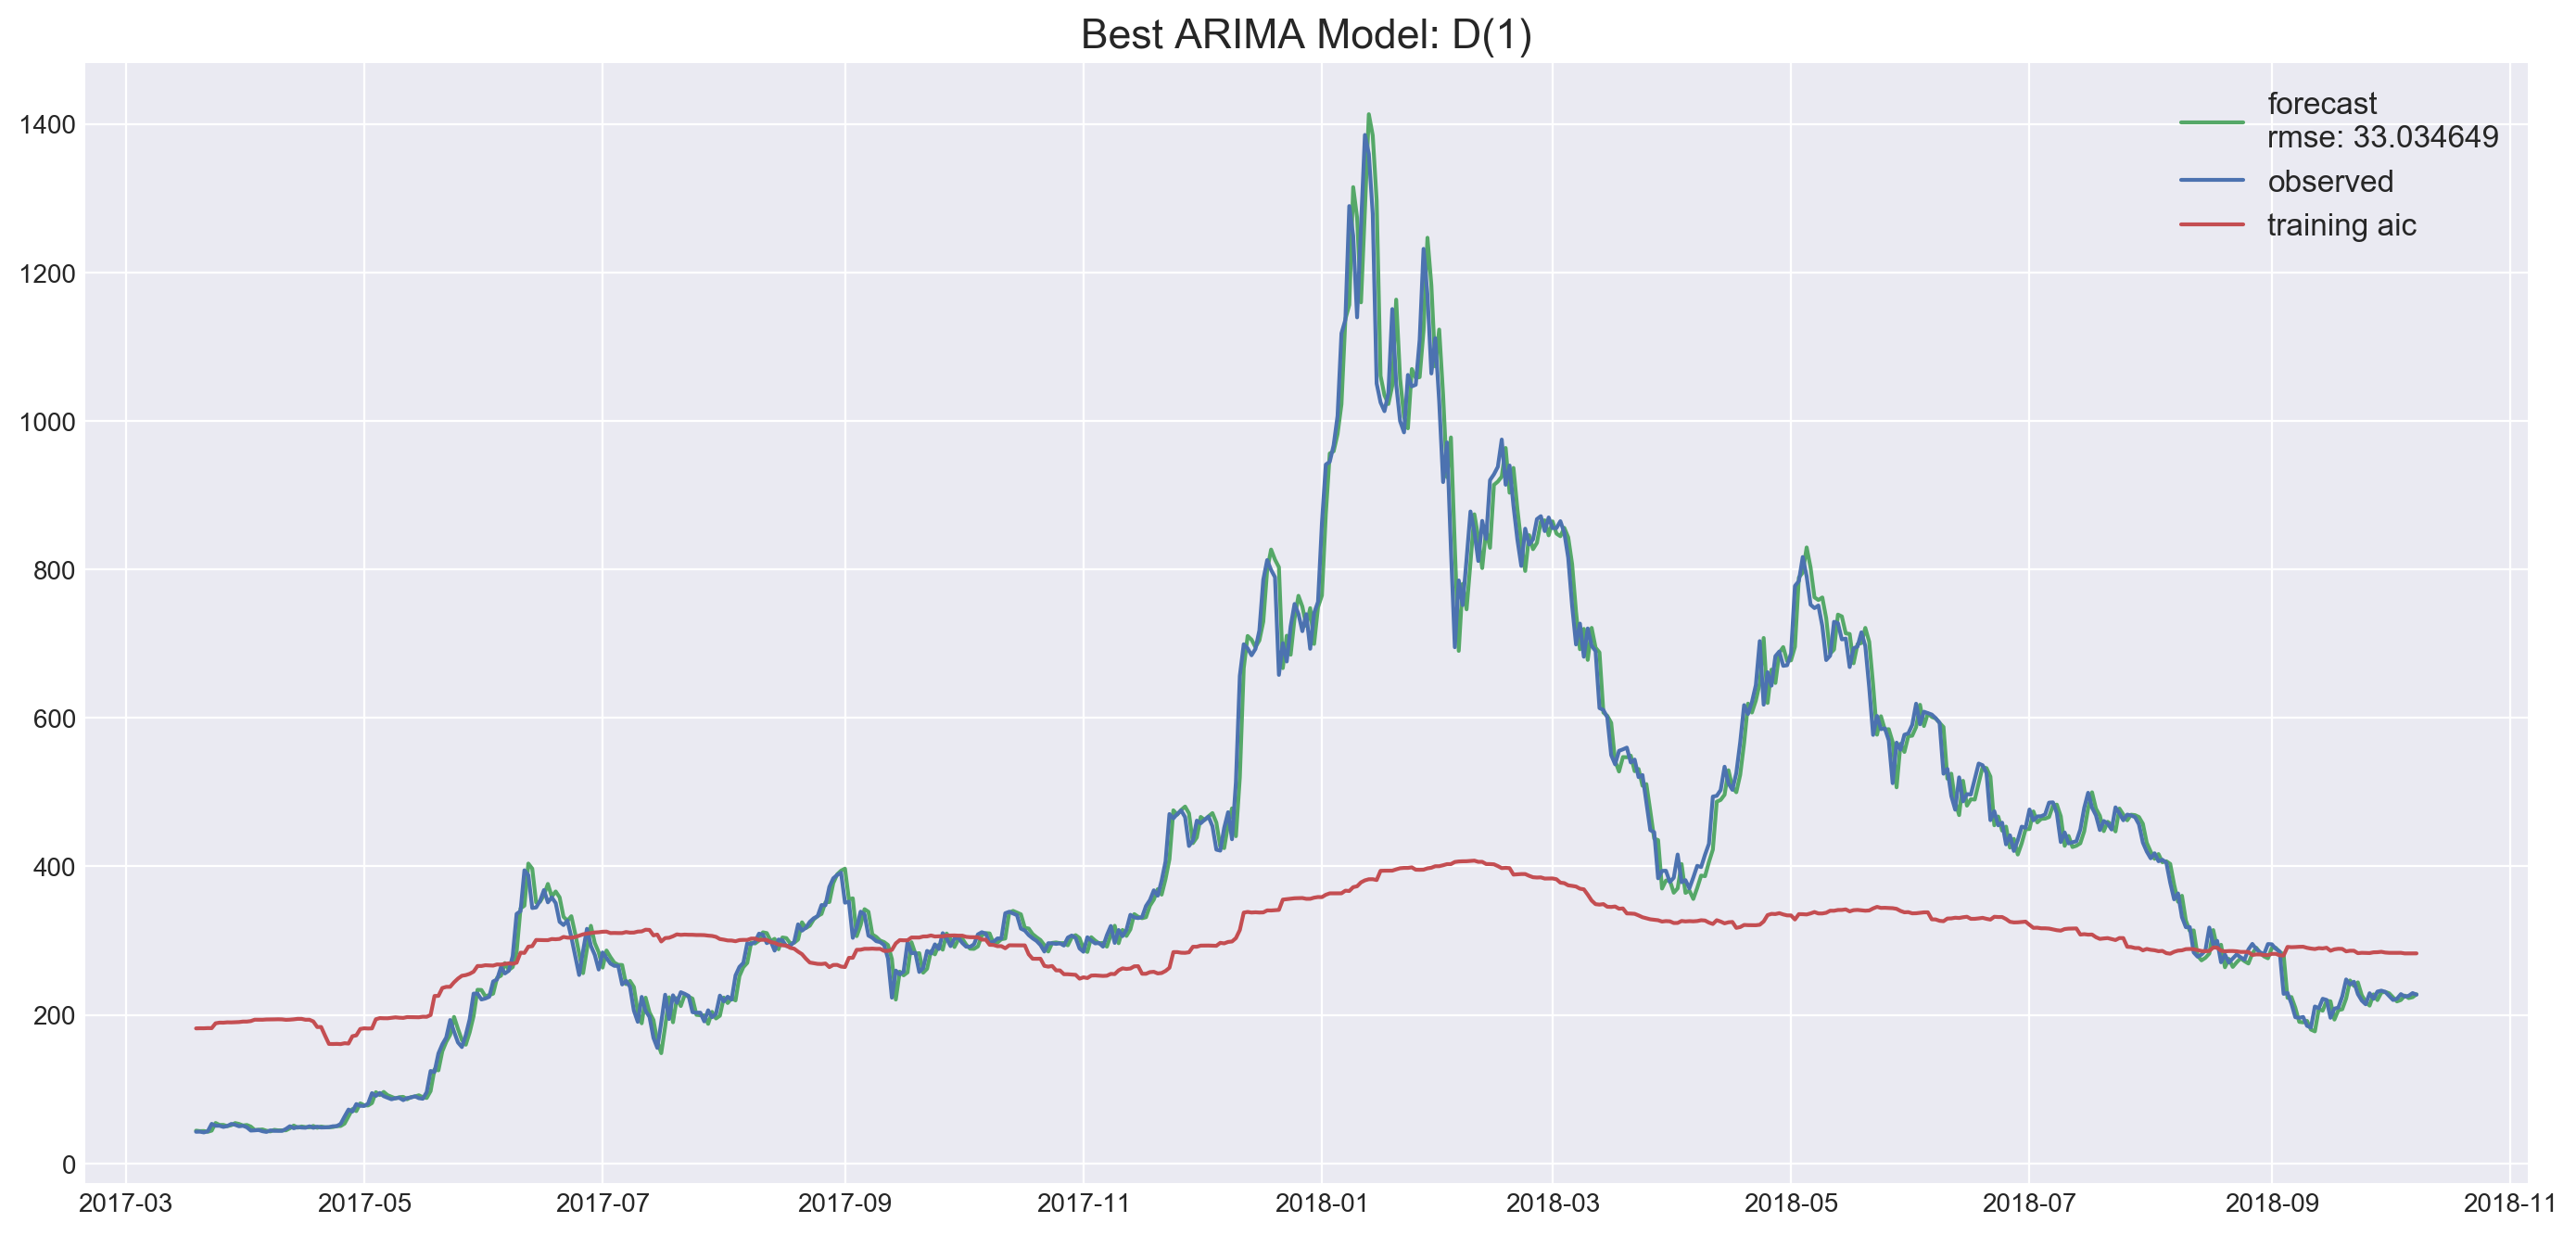

In [59]:
# plot results
x_dates = ts.eth_close.index[window:]
observed = ts.eth_close[window:]

fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
ax.set_title("Best ARIMA Model: D(1)", size=title_fontsize)
# best arima
ax.plot(
    x_dates,
    forecasts[best_model][0],
    label="forecast\nrmse: {:.6f}".format(arima_preds_rmse[best_model]),
    c=colors[1]
)
# plot observed values
ax.plot(
    x_dates,
    observed,
    label = "observed",
    c=colors[0]
)
# plot train aic for fun
ax.plot(
    x_dates,
    forecasts[best_model][1],
    label="training aic",
    c=colors[2]
)
#plt.setp(ax.lines, linewidth=1.5)
plt.legend(prop={'size':ax_fontsize})
plt.show()

### ARIMA Results:
- Best RMSE: diff1 models
- Model performance when using AR/MA component suffers
- Structural Breaks:
    - Including changepoints slightly increases error
    - Either:
        - Model is capturing this on it's own
        - Calculated change points are not very accurate

<a id='ann'></a>
## 3.2 Artifical Neural Networks

In [60]:
def shift_data(df, n_shifts):
    # copy df, shift cols in a new df and concat them
    df_shifted = df.copy()
    for i in range(n_shifts):
        df = pd.concat([df, df_shifted.shift(i+1)], axis=1)
        df.dropna(axis=0, inplace=True)
    
    # rename columns    
    cols = list(df.columns)[1:]
    for i, col in enumerate(cols):
        cols[i] = 'shift_{}'.format(i+1)
    cols = [df.columns[0]] + cols
    df.columns = cols
    return df

def shape_data(data):
    data = np.array(data).reshape(data.shape[0], data.shape[1], 1)
    return data

def build_lstm(X, loss, optimizer, lr, units=1, activation='tanh', use_bias=True):
    model = Sequential()
    model.add(LSTM(
        units=units,
        activation='tanh',
        use_bias=use_bias,
        input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))

    model.compile(
        loss=loss,
        metrics=['mse'],
        optimizer=optimizer
    )
    return model

def lstm_forecast(model, X, y, window, epochs, verbose=0, callbacks=None):
    start = 0
    stop = window
    preds = []
    observed = ts.eth_close.values[-(len(X)-window):]
    
    for i in range(len(y) - window):
                
        # set train data to window sized chunk
        X_train, y_train = X[start:stop], y[start:stop]
        # set test data to one step after train data
        X_test, y_test = X[stop:stop + 1], y[stop:stop + 1]
        
        # fit model
        start_time = time.time()
        model.fit(
            X_train,
            y_train,
            epochs=epochs,
            verbose=verbose,
            callbacks=callbacks,
            validation_split=0.1
        )
        # make & store prediction, step foreward
        yhat = model.predict(X_test)
        yhat = scaler.inverse_transform(yhat[0][0])
        preds.append(yhat)
        
        # monitor function without model verbosity
        if start != 0 and start % 100  == 0:
            print("iteration {} predicted: {} (observed: {}) in {:.2f} seconds".format(
                start, yhat, observed[start], (time.time()-start_time)))
            
        start += 1
        stop += 1
    return preds

def lstm_rmse(preds):
    rmse = np.sqrt(mean_squared_error(ts.eth_close.values[-len(preds):],
                                      np.array(preds).reshape(len(preds),)))
    return rmse

In [61]:
# set series to manipulate for ANNs
ts_nn = pd.DataFrame(ts.eth_close.copy())
ts_nn.rename(columns={'eth_close':'unshifted'}, inplace=True)

# scale data
scaler = MinMaxScaler(feature_range=(0,1))
ts_scaled = scaler.fit_transform(ts_nn.values)
ts_nn = pd.DataFrame(ts_scaled).set_index(ts_nn.index.values)
ts_nn.columns = ['unshifted']
print("original df:\nshape: {}".format(ts_nn.shape))
#display(ts_nn.head(3), ts_nn.tail(3))

# shift dataset
ts_nn = shift_data(ts_nn, n_shifts=1)
print("shifted df:\nshape: {}".format(ts_nn.shape))
#display(ts_nn.head(3), ts_nn.tail(3))

# set data/target
X = ts_nn.loc[:, ~ts_nn.columns.isin(['unshifted'])]
y = ts_nn.unshifted
#print(X.shape, y.shape)

# reshape
X = shape_data(X)
print("Final shapes X, y: {}, {}".format(X.shape, y.shape))

original df:
shape: (604, 1)
shifted df:
shape: (603, 2)
Final shapes X, y: (603, 1, 1), (603,)


## LSTM Models
- GridSearchCV isn't cooperating, either I don't have it set up correctly or it's just incredibly slow
- Run 3 optimizers with default learning rates
- If time, tune LR and units

In [62]:
# window size for rolling forecast
window = 35

# set dict to store results
lstm_results = {}

# callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=25,
    verbose=0
)

In [63]:
# compile
lstm = build_lstm(
    X=X,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='Adam',
    lr=0.001
)
# train & forecast
start_time = time.time()
adamlr001 = lstm_forecast(
    model=lstm,
    window=window,
    X=X,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(adamlr001)))
lstm_results.update({"adamlr001": lstm_rmse(adamlr001)})

iteration 100 predicted: [[318.81903]] (observed: 292.9) in 0.07 seconds
iteration 200 predicted: [[301.91885]] (observed: 311.26) in 0.08 seconds
iteration 300 predicted: [[1365.2789]] (observed: 1278.69) in 0.11 seconds
iteration 400 predicted: [[698.73615]] (observed: 617.73) in 0.27 seconds
iteration 500 predicted: [[431.99612]] (observed: 417.62) in 0.07 seconds
runtime: 102.24 seconds
rmse: 37.15308453879473


In [64]:
# compile
lstm = build_lstm(
    X=X,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='RMSprop',
    lr=0.001
)

# train & forecast
start_time = time.time()
rmsproplr001 = lstm_forecast(
    model=lstm,
    window=window,
    X=X,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(rmsproplr001)))
lstm_results.update({"rmsproplr001": lstm_rmse(rmsproplr001)})

iteration 100 predicted: [[320.66064]] (observed: 292.9) in 0.06 seconds
iteration 200 predicted: [[301.18787]] (observed: 311.26) in 0.09 seconds
iteration 300 predicted: [[1320.7865]] (observed: 1278.69) in 0.06 seconds
iteration 400 predicted: [[716.415]] (observed: 617.73) in 1.18 seconds
iteration 500 predicted: [[431.34787]] (observed: 417.62) in 0.08 seconds
runtime: 157.38 seconds
rmse: 39.07241030424384


In [65]:
# compile
lstm = build_lstm(
    X=X,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='Adadelta',
    lr=1.0
)
# train & forecast
start_time = time.time()
adadeltalr1 = lstm_forecast(
    model=lstm,
    window=window,
    X=X,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(adadeltalr1)))
lstm_results.update({"adadeltalr1": lstm_rmse(adadeltalr1)})

iteration 100 predicted: [[344.35046]] (observed: 292.9) in 1.37 seconds
iteration 200 predicted: [[311.71542]] (observed: 311.26) in 1.32 seconds
iteration 300 predicted: [[1234.1588]] (observed: 1278.69) in 0.06 seconds
iteration 400 predicted: [[697.17993]] (observed: 617.73) in 0.07 seconds
iteration 500 predicted: [[437.39175]] (observed: 417.62) in 1.39 seconds
runtime: 226.01 seconds
rmse: 55.203556763901055


In [66]:
print(min(lstm_results, key=lstm_results.get))

adamlr001


### Tune Learning Rate

In [67]:
tuned_results = {'adamlr001':lstm_rmse(adamlr001)}

In [68]:
# compile
lstm = build_lstm(
    X=X,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='Adam',
    lr=0.005
)
# train & forecast
start_time = time.time()
adamlr005 = lstm_forecast(
    model=lstm,
    window=window,
    X=X,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(adamlr005)))
tuned_results.update({"adamlr005": lstm_rmse(adamlr005)})

iteration 100 predicted: [[318.93387]] (observed: 292.9) in 0.09 seconds
iteration 200 predicted: [[302.1286]] (observed: 311.26) in 0.08 seconds
iteration 300 predicted: [[1366.7238]] (observed: 1278.69) in 0.13 seconds
iteration 400 predicted: [[703.6504]] (observed: 617.73) in 0.29 seconds
iteration 500 predicted: [[431.88425]] (observed: 417.62) in 0.10 seconds
runtime: 119.16 seconds
rmse: 37.349899160422815


In [69]:
# compile
lstm = build_lstm(
    X=X,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='Adam',
    lr=0.002
)
# train & forecast
start_time = time.time()
adamlr002 = lstm_forecast(
    model=lstm,
    window=window,
    X=X,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(adamlr002)))
tuned_results.update({"adamlr002": lstm_rmse(adamlr002)})

iteration 100 predicted: [[318.55878]] (observed: 292.9) in 0.07 seconds
iteration 200 predicted: [[302.09796]] (observed: 311.26) in 0.08 seconds
iteration 300 predicted: [[1370.6819]] (observed: 1278.69) in 0.12 seconds
iteration 400 predicted: [[702.6758]] (observed: 617.73) in 0.31 seconds
iteration 500 predicted: [[432.02795]] (observed: 417.62) in 0.08 seconds
runtime: 113.46 seconds
rmse: 37.487468910407884


In [70]:
# compile
lstm = build_lstm(
    X=X,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='Adam',
    lr=0.0005
)
# train & forecast
start_time = time.time()
adamlr0005 = lstm_forecast(
    model=lstm,
    window=window,
    X=X,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(adamlr0005)))
tuned_results.update({"adamlr0005": lstm_rmse(adamlr0005)})

iteration 100 predicted: [[318.4119]] (observed: 292.9) in 0.07 seconds
iteration 200 predicted: [[301.99423]] (observed: 311.26) in 0.08 seconds
iteration 300 predicted: [[1341.2844]] (observed: 1278.69) in 0.10 seconds
iteration 400 predicted: [[708.7465]] (observed: 617.73) in 0.31 seconds
iteration 500 predicted: [[431.91342]] (observed: 417.62) in 0.08 seconds
runtime: 119.83 seconds
rmse: 36.887467320631636


In [71]:
# compile
lstm = build_lstm(
    X=X,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='Adam',
    lr=0.0001
)
# train & forecast
start_time = time.time()
adamlr0001 = lstm_forecast(
    model=lstm,
    window=window,
    X=X,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(adamlr0001)))
tuned_results.update({"adamlr0001": lstm_rmse(adamlr0001)})

iteration 100 predicted: [[319.54147]] (observed: 292.9) in 0.07 seconds
iteration 200 predicted: [[302.1821]] (observed: 311.26) in 0.07 seconds
iteration 300 predicted: [[1369.664]] (observed: 1278.69) in 0.11 seconds
iteration 400 predicted: [[701.9737]] (observed: 617.73) in 0.30 seconds
iteration 500 predicted: [[432.04648]] (observed: 417.62) in 0.08 seconds
runtime: 149.23 seconds
rmse: 37.98555777407777


In [72]:
print(min(tuned_results, key=tuned_results.get))

adamlr0005


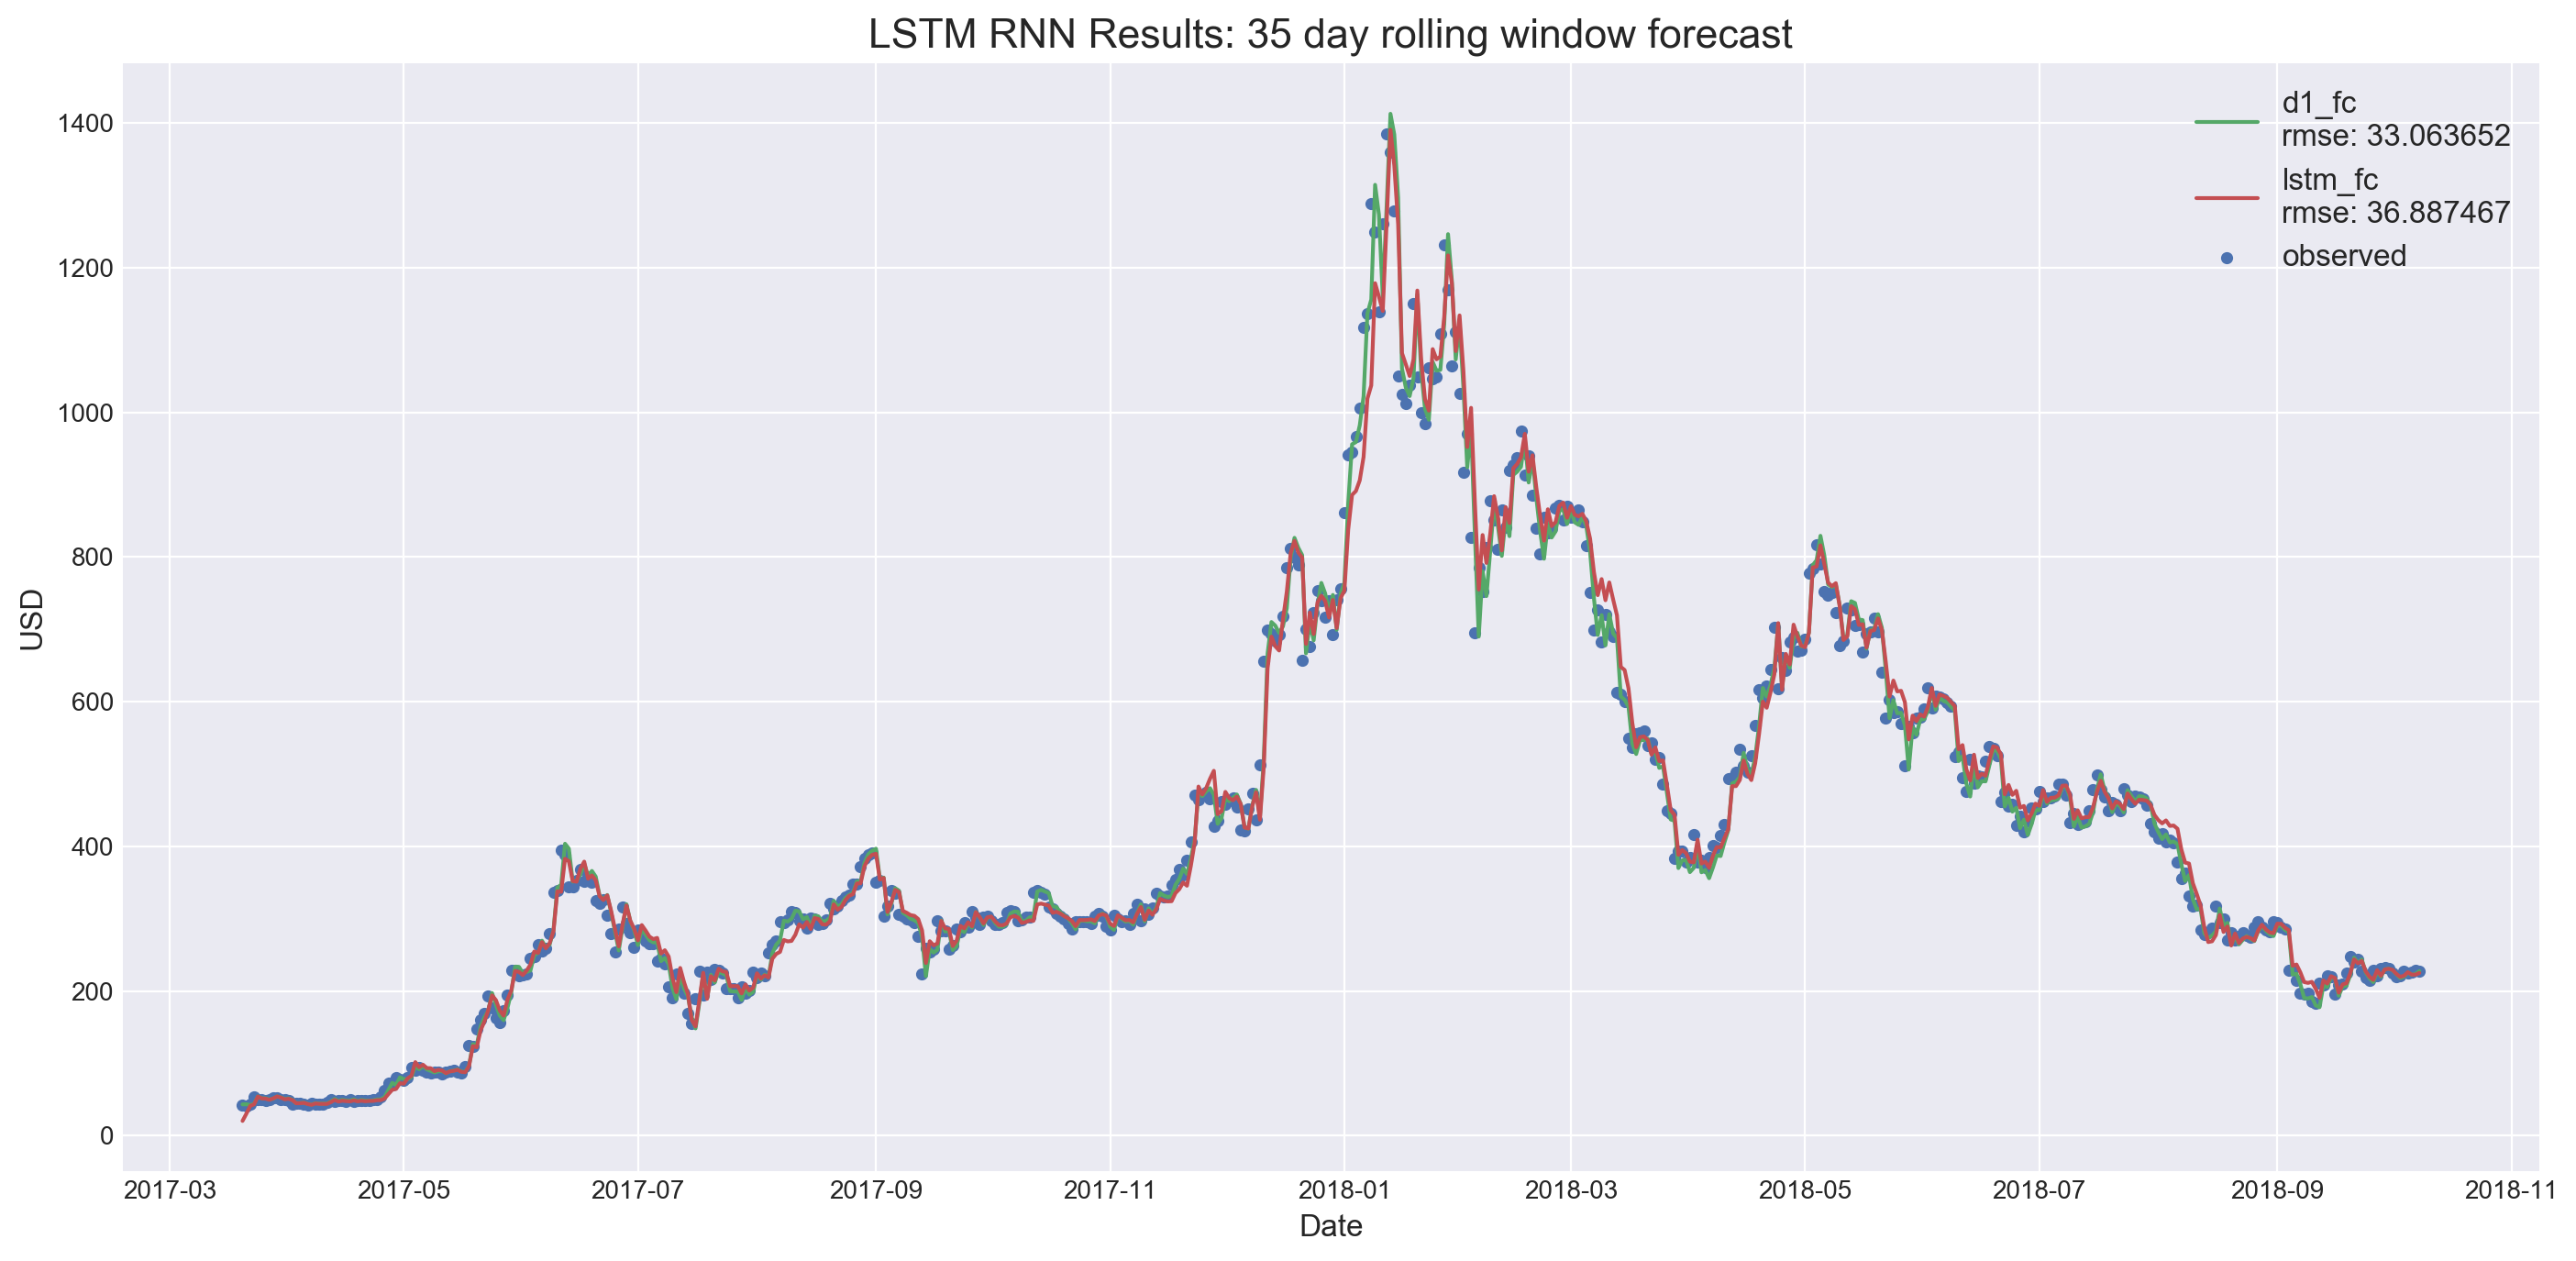

In [73]:
# compare best LSTM to same set of forecasts from ARIMA
best_lstm = adamlr0005

# exclude arima predicted values that aren't predicted by lstm
d1_fc_rmse = np.sqrt(mean_squared_error(
    ts.eth_close.values[-len(best_lstm):], d1_fc[0][-len(best_lstm):]))

fig, ax = plt.subplots(figsize=figsize1, dpi=dpi)
# observed
ax.scatter(
    ts.eth_close[-len(best_lstm):].index,
    ts.eth_close.values[-len(best_lstm):],
    label="observed",
    c=colors[0],
    s=14
)
# arima forecast
ax.plot(
    ts.eth_close[-len(best_lstm):].index,
    d1_fc[0][-len(best_lstm):],
    label="d1_fc\nrmse: {:.6f}".format(d1_fc_rmse),
    c=colors[1]
)
# lstm forecast
ax.plot(
    ts.eth_close[-len(best_lstm):].index,
    np.array(best_lstm).reshape(len(best_lstm),),
    label="lstm_fc\nrmse: {:.6f}".format(lstm_rmse(best_lstm)),
    c=colors[2]
)
ax.set_title("LSTM RNN Results: {} day rolling window forecast".format(window), size=title_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.legend(prop={'size':ax_fontsize})
plt.show()

# 4. Time Series with Exogenous Variables

In [74]:
# eth related
exog_eth = raw[
    ['eth_open', 'eth_high', 'eth_low', 'eth_volumefrom', 'eth_volumeto']
][break_points[0]:].copy()
display(exog_eth.head(1))

# missingness check
for col in exog_eth.columns:
    n_missing = exog_eth['{}'.format(col)].isnull().sum()
    print("\n{}\nmissing: {}, {:.2f}% of total".format(
            col, n_missing, (n_missing/len(exog_eth)*100)))

,eth_open,eth_high,eth_low,eth_volumefrom,eth_volumeto
2017-02-12,11.42,11.49,11.19,92414.71,1044736.73



eth_open
missing: 0, 0.00% of total

eth_high
missing: 0, 0.00% of total

eth_low
missing: 0, 0.00% of total

eth_volumefrom
missing: 0, 0.00% of total

eth_volumeto
missing: 0, 0.00% of total


In [75]:
# other crypto prices
exog_coins = raw[
    ['btc_close', 'xrp_close', 'eos_close', 'ltc_close', 'xlm_close', 'xmr_close']
][break_points[0]:].copy()
display(exog_coins.head(1))

# missingness check
for col in exog_coins.columns:
    n_missing = exog_coins['{}'.format(col)].isnull().sum()
    print("\n{}\nmissing: {}, {:.2f}% of total".format(
            col, n_missing, (n_missing/len(exog_coins)*100)))

# significant portions of eos & xlm missing, drop features
exog_coins.drop(['eos_close', 'xlm_close'], axis=1, inplace=True)
display(exog_coins.head(1))

,btc_close,xrp_close,eos_close,ltc_close,xlm_close,xmr_close
2017-02-12,995.36,0.00624,NaN,3.74,0.002168,12.39



btc_close
missing: 0, 0.00% of total

xrp_close
missing: 0, 0.00% of total

eos_close
missing: 136, 22.52% of total

ltc_close
missing: 0, 0.00% of total

xlm_close
missing: 0, 0.00% of total

xmr_close
missing: 0, 0.00% of total


,btc_close,xrp_close,ltc_close,xmr_close
2017-02-12,995.36,0.00624,3.74,12.39


In [76]:
# other index related
exog_idx = raw[
    ['vixcls', 'twexb', 'effr']
][break_points[0]:].copy()
display(exog_idx.head(1))

# missingness check
for col in exog_idx.columns:
    n_missing = exog_idx['{}'.format(col)].isnull().sum()
    print("\n{}\nmissing: {}, {:.2f}% of total".format(
            col, n_missing, (n_missing/len(exog_idx)*100)))

,vixcls,twexb,effr
2017-02-12,10.85,125.493,0.66



vixcls
missing: 0, 0.00% of total

twexb
missing: 0, 0.00% of total

effr
missing: 0, 0.00% of total


## Granger Causality

In [148]:
def granger_causality(var1, var2, diff=1):
    
    if diff is not None:
        df = pd.concat([var1, var2], axis=1)
        results = grangercausalitytests(
            df[['{}'.format(df.columns[0]), '{}'.format(df.columns[1])]],
            maxlag=1, verbose=False)[1][0]
        return results

In [160]:
# put all in one df
exog_all = pd.concat([exog_eth, exog_coins, exog_idx], axis=1)
exog_all.head(1)

,eth_open,eth_high,eth_low,eth_volumefrom,eth_volumeto,btc_close,xrp_close,ltc_close,xmr_close,vixcls,twexb,effr
2017-02-12,11.42,11.49,11.19,92414.71,1044736.73,995.36,0.00624,3.74,12.39,10.85,125.493,0.66


In [170]:
# granger causality tests
gc_all = {}
gc_sig = []

for col in exog_all.columns:
    results = granger_causality(ts.eth_close, exog_all['{}'.format(col)])
    gc_all.update({col:results})
    for key, value in results.items():
        if value[1] <= 0.05:
            if col not in gc_sig:
                gc_sig.append(col)
                
for var in gc_sig:
    print("\n{}".format(var))
    print(gc_all['{}'.format(var)])


eth_low
{'ssr_ftest': (7.9743220127612044, 0.0049021054477978885, 600.0, 1), 'ssr_chi2test': (8.014193622825012, 0.004641213533102584, 1), 'lrtest': (7.961404372889774, 0.004778532281210878, 1), 'params_ftest': (7.974322012760752, 0.004902105447798869, 600.0, 1.0)}

eth_volumefrom
{'ssr_ftest': (4.666394144072292, 0.0311537167066728, 600.0, 1), 'ssr_chi2test': (4.689726114792654, 0.030343483632848032, 1), 'lrtest': (4.671583363377067, 0.030665643159943953, 1), 'params_ftest': (4.666394144068057, 0.031153716706750843, 600.0, 1.0)}

eth_volumeto
{'ssr_ftest': (9.420394597590969, 0.0022427521169137397, 600.0, 1), 'ssr_chi2test': (9.467496570578923, 0.002091445972734036, 1), 'lrtest': (9.393942508415421, 0.0021770353913356084, 1), 'params_ftest': (9.42039459733446, 0.002242752117222502, 600.0, 1.0)}

btc_close
{'ssr_ftest': (14.362010938231295, 0.00016603717432612776, 600.0, 1), 'ssr_chi2test': (14.43382099292245, 0.0001451715944438324, 1), 'lrtest': (14.263780210932964, 0.000158893165187

In [172]:
gc_reverse_all = {}
gc_reverse_sig = []

for col in exog_all_df.columns:
    results = granger_causality(exog_all['{}'.format(col)], ts.eth_close)
    gc_reverse_all.update({col:results})
    for key, value in results.items():
        if value[1] <= 0.05:
            if col not in gc_reverse_sig:
                gc_reverse_sig.append(col)
                
for var in gc_reverse_sig:
    print("\n{}".format(var))
    print(gc_reverse_all['{}'.format(var)])


eth_open
{'ssr_ftest': (108524090.0184235, 0.0, 600.0, 1), 'ssr_chi2test': (109066710.46851562, 0.0, 1), 'lrtest': (7299.651840391717, 0.0, 1), 'params_ftest': (108524090.01842353, 0.0, 600.0, 1.0)}

eth_high
{'ssr_ftest': (420.072936249827, 3.633455489630375e-71, 600.0, 1), 'ssr_chi2test': (422.1733009310762, 8.211159515870414e-94, 1), 'lrtest': (320.0119520437047, 1.4397856038040615e-71, 1), 'params_ftest': (420.07293624984277, 3.6334554896135416e-71, 600.0, 1.0)}

eth_low
{'ssr_ftest': (282.86475313019565, 2.7254964161069504e-52, 600.0, 1), 'ssr_chi2test': (284.27907689584663, 8.772753119821544e-64, 1), 'lrtest': (232.9041468146852, 1.386798860748701e-52, 1), 'params_ftest': (282.864753130189, 2.7254964161131088e-52, 600.0, 1.0)}

eth_volumeto
{'ssr_ftest': (77.98401468226422, 1.1387940776261602e-17, 600.0, 1), 'ssr_chi2test': (78.37393475567553, 8.526990355457134e-19, 1), 'lrtest': (73.68301533474005, 9.172475058342753e-18, 1), 'params_ftest': (77.98401468226422, 1.138794077626160

In [180]:
exog_gc = exog_all.loc[:, exog_all.columns.isin(['eth_low',
 'eth_volumefrom',
 'eth_volumeto',
 'btc_close',
 'xrp_close',
 'ltc_close',
 'xmr_close'])].copy()

# 5. Modeling & Forecasting with Exogenous Variables

### ARIMA

In [182]:
# set endog
y = ts.eth_close[1:]

# shift data
exog_eth_df = exog_eth.copy().shift(1).dropna()
exog_coins_df = exog_coins.copy().shift(1).dropna()
exog_idx_df = exog_idx.copy().shift(1).dropna()
exog_gc_df = exog_gc.copy().shift(1).dropna()
exog_all_df = exog_all.copy().shift(1).dropna()

In [184]:
window = 30
order = (0,1,0)

print("d1 rmse ts only: {}".format(d1_fc_rmse))
d1x_eth = arima_forecast(
    endog=y,
    exog=exog_eth_df,
    order=order,
    window=window
)
print("d1x_eth rmse: {}".format(rmse(ts.eth_close[1 + window:], d1x_eth[0])))

d1x_coins = arima_forecast(
    endog=y,
    exog=exog_coins_df,
    order=order,
    window=window
)
print("d1x_coins rmse: {}".format(rmse(ts.eth_close[1 + window:], d1x_coins[0])))

d1x_idx  = arima_forecast(
    endog=y,
    exog=exog_idx_df,
    order=order,
    window=window
)
print("d1x_idx rmse: {}".format(rmse(ts.eth_close[1 + window:], d1x_idx[0])))

d1x_gc  = arima_forecast(
    endog=y,
    exog=exog_gc_df,
    order=order,
    window=window
)
print("d1x_gc rmse: {}".format(rmse(ts.eth_close[1 + window:], d1x_gc[0])))

d1x_all = arima_forecast(
    endog=y,
    exog=exog_all_df,
    order=order,
    window=window
)
print("d1x_all rmse: {}".format(rmse(y[window:], d1x_all[0])))

d1 rmse ts only: 33.063652299287604
d1x_eth rmse: 38.185205635047645
d1x_coins rmse: 36.94226800183506
d1x_idx rmse: 37.18097414566442
d1x_gc rmse: 42.13752762885691
d1x_all rmse: 62.37581836411433


## LSTM RNN

In [185]:
lstm_exog_results = {}
window = 30

### Ethereum Exog

In [194]:
lr = 0.001

In [195]:
lstm_eth_df = exog_eth.copy()
lstm_eth_df['eth_close'] = ts.eth_close.copy()
display(lstm_eth_df.head(1))

# set data/target
X_eth = lstm_eth_df.shift(1).copy().dropna()
y = lstm_eth_df.eth_close[1:]
print(X_eth.shape, y.shape)

scaler = MinMaxScaler(feature_range=(0,1))
X_eth_scaled = scaler.fit_transform(X_eth.values)
y = scaler.fit_transform(np.array(y).reshape(-1,1))

X_eth = shape_data(X_eth_scaled)
print(X_eth.shape, y.shape)

,eth_open,eth_high,eth_low,eth_volumefrom,eth_volumeto,eth_close
2017-02-12,11.42,11.49,11.19,92414.71,1044736.73,11.39


(603, 6) (603,)
(603, 6, 1) (603, 1)


In [196]:
# compile
lstm = build_lstm(
    X=X_eth,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='Adam',
    lr=lr
)
# train & forecast
start_time = time.time()
adam_eth = lstm_forecast(
    model=lstm,
    window=window,
    X=X_eth,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(adam_eth)))
lstm_exog_results.update({"adam_eth": lstm_rmse(adam_eth)})

iteration 100 predicted: [[336.54202]] (observed: 304.54) in 0.21 seconds
iteration 200 predicted: [[297.40387]] (observed: 296.81) in 0.21 seconds
iteration 300 predicted: [[989.1108]] (observed: 1248.99) in 0.51 seconds
iteration 400 predicted: [[552.26855]] (observed: 617.16) in 0.20 seconds
iteration 500 predicted: [[467.21207]] (observed: 466.2) in 2.58 seconds
runtime: 414.76 seconds
rmse: 46.189986343748366


### Coin Exog

In [197]:
lstm_coins_df = exog_coins.copy()
lstm_coins_df['eth_close'] = ts.eth_close.copy()
display(lstm_coins_df.head(1))

# set data/target
X_coins = lstm_coins_df.shift(1).copy().dropna()
y = lstm_coins_df.eth_close[1:]
print(X_coins.shape, y.shape)

scaler = MinMaxScaler(feature_range=(0,1))
X_coins_scaled = scaler.fit_transform(X_coins.values)
y = scaler.fit_transform(np.array(y).reshape(-1,1))

X_coins = shape_data(X_coins_scaled)
print(X_coins.shape, y.shape)

,btc_close,xrp_close,ltc_close,xmr_close,eth_close
2017-02-12,995.36,0.00624,3.74,12.39,11.39


(603, 5) (603,)
(603, 5, 1) (603, 1)


In [198]:
# compile
lstm = build_lstm(
    X=X_coins,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='Adam',
    lr=lr
)
# train & forecast
start_time = time.time()
adam_coins = lstm_forecast(
    model=lstm,
    window=window,
    X=X_coins,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(adam_coins)))
lstm_exog_results.update({"adam_coins": lstm_rmse(adam_coins)})

iteration 100 predicted: [[335.15826]] (observed: 304.54) in 0.17 seconds
iteration 200 predicted: [[307.98398]] (observed: 296.81) in 0.16 seconds
iteration 300 predicted: [[985.5181]] (observed: 1248.99) in 0.17 seconds
iteration 400 predicted: [[506.9165]] (observed: 617.16) in 0.29 seconds
iteration 500 predicted: [[466.70236]] (observed: 466.2) in 0.16 seconds
runtime: 341.91 seconds
rmse: 53.567598834876044


### Other Indicators Exog

In [199]:
lstm_idx_df = exog_idx.copy()
lstm_idx_df['eth_close'] = ts.eth_close.copy()
display(lstm_idx_df.head(1))

# set data/target
X_idx = lstm_idx_df.shift(1).copy().dropna()
y = lstm_idx_df.eth_close[1:]
print(X_idx.shape, y.shape)

scaler = MinMaxScaler(feature_range=(0,1))
X_idx_scaled = scaler.fit_transform(X_idx.values)
y = scaler.fit_transform(np.array(y).reshape(-1,1))

X_idx = shape_data(X_idx_scaled)
print(X_idx.shape, y.shape)

,vixcls,twexb,effr,eth_close
2017-02-12,10.85,125.493,0.66,11.39


(603, 4) (603,)
(603, 4, 1) (603, 1)


In [200]:
# compile
lstm = build_lstm(
    X=X_idx,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='Adam',
    lr=lr
)
# train & forecast
start_time = time.time()
adam_idx = lstm_forecast(
    model=lstm,
    window=window,
    X=X_idx,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(adam_idx)))
lstm_exog_results.update({"adam_idx": lstm_rmse(adam_idx)})

iteration 100 predicted: [[329.5061]] (observed: 304.54) in 0.15 seconds
iteration 200 predicted: [[280.5341]] (observed: 296.81) in 0.15 seconds
iteration 300 predicted: [[1074.43]] (observed: 1248.99) in 0.29 seconds
iteration 400 predicted: [[559.4394]] (observed: 617.16) in 2.55 seconds
iteration 500 predicted: [[466.81256]] (observed: 466.2) in 0.14 seconds
runtime: 294.66 seconds
rmse: 45.96201188808123


## GC Exog

In [201]:
lstm_gc_df = exog_gc.copy()
lstm_gc_df['eth_close'] = ts.eth_close.copy()
display(lstm_gc_df.head(1))

# set data/target
X_gc = lstm_gc_df.shift(1).copy().dropna()
y = lstm_gc_df.eth_close[1:]
print(X_gc.shape, y.shape)

scaler = MinMaxScaler(feature_range=(0,1))
X_gc_scaled = scaler.fit_transform(X_gc.values)
y = scaler.fit_transform(np.array(y).reshape(-1,1))

X_gc = shape_data(X_gc_scaled)
print(X_gc.shape, y.shape)

,eth_low,eth_volumefrom,eth_volumeto,btc_close,xrp_close,ltc_close,xmr_close,eth_close
2017-02-12,11.19,92414.71,1044736.73,995.36,0.00624,3.74,12.39,11.39


(603, 8) (603,)
(603, 8, 1) (603, 1)


In [205]:
# compile
lstm = build_lstm(
    X=X_gc,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='Adam',
    lr=lr
)
# train & forecast
start_time = time.time()
adam_gc = lstm_forecast(
    model=lstm,
    window=window,
    X=X_gc,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(adam_gc)))
lstm_exog_results.update({"adam_gc": lstm_rmse(adam_gc)})

iteration 100 predicted: [[334.60992]] (observed: 304.54) in 0.43 seconds
iteration 200 predicted: [[308.7082]] (observed: 296.81) in 0.23 seconds
iteration 300 predicted: [[978.6727]] (observed: 1248.99) in 0.25 seconds
iteration 400 predicted: [[542.48004]] (observed: 617.16) in 0.28 seconds
iteration 500 predicted: [[464.51483]] (observed: 466.2) in 0.25 seconds
runtime: 522.99 seconds
rmse: 46.279173760984136


### All Exog

In [203]:
lstm_all_df = pd.concat([exog_eth.copy(), exog_coins.copy(), exog_idx.copy()], axis=1)
lstm_all_df['eth_close'] = ts.eth_close.copy()
display(lstm_all_df.head(1))

# set data/target
X_all = lstm_all_df.shift(1).copy().dropna()
y = lstm_all_df.eth_close[1:]
print(X_all.shape, y.shape)

scaler = MinMaxScaler(feature_range=(0,1))
X_all_scaled = scaler.fit_transform(X_all)
y = scaler.fit_transform(np.array(y).reshape(-1,1))

X_all = shape_data(X_all_scaled)
print(X_all.shape, y.shape)

,eth_open,eth_high,eth_low,eth_volumefrom,eth_volumeto,btc_close,xrp_close,ltc_close,xmr_close,vixcls,twexb,effr,eth_close
2017-02-12,11.42,11.49,11.19,92414.71,1044736.73,995.36,0.00624,3.74,12.39,10.85,125.493,0.66,11.39


(603, 13) (603,)
(603, 13, 1) (603, 1)


In [204]:
# compile
lstm = build_lstm(
    X=X_all,
    units=1,
    activation='tanh',
    loss='mean_squared_error',
    optimizer='Adam',
    lr=lr
)
# train & forecast
start_time = time.time()
adam_all = lstm_forecast(
    model=lstm,
    window=window,
    X=X_all,
    y=y,
    epochs=500,
    callbacks=[early_stopping]
)
# print and store results
print("runtime: {:.2f} seconds".format(time.time() - start_time))
print("rmse: {}".format(lstm_rmse(adam_all)))
lstm_exog_results.update({"adam_all": lstm_rmse(adam_all)})

iteration 100 predicted: [[328.17606]] (observed: 304.54) in 0.33 seconds
iteration 200 predicted: [[285.40094]] (observed: 296.81) in 0.34 seconds
iteration 300 predicted: [[1087.467]] (observed: 1248.99) in 0.37 seconds
iteration 400 predicted: [[596.32294]] (observed: 617.16) in 0.39 seconds
iteration 500 predicted: [[464.96585]] (observed: 466.2) in 0.55 seconds
runtime: 624.47 seconds
rmse: 45.50584252656124


In [206]:
print(min(lstm_exog_results, key=lstm_exog_results.get))

adam_all


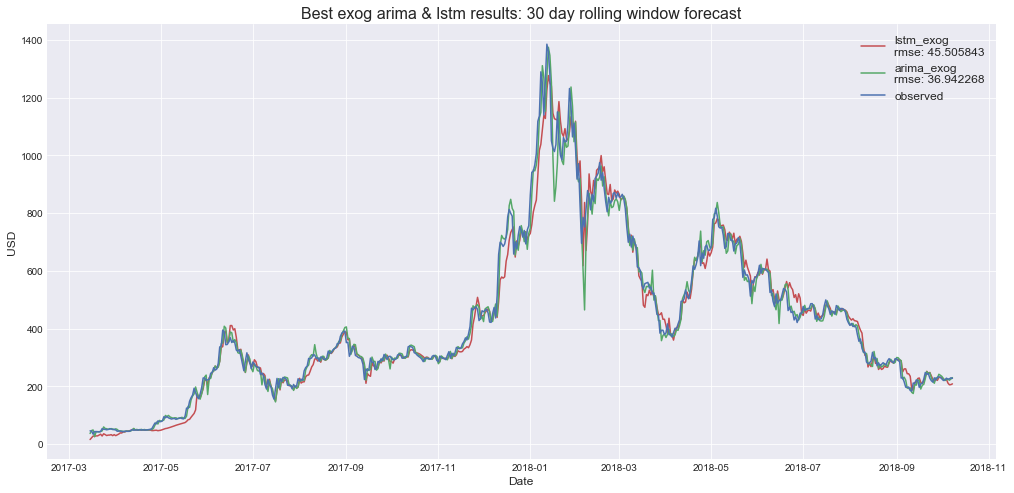

In [211]:
# best arima exog vs. best lstm exog
best_arima_exog = d1x_coins
best_lstm_exog = adam_all

fig, ax = plt.subplots(figsize=figsize1)
# lstm forecast
ax.plot(
    ts.eth_close[-len(best_lstm_exog):].index,
    np.array(best_lstm_exog).reshape(len(best_lstm_exog),),
    label="lstm_exog\nrmse: {:.6f}".format(lstm_rmse(best_lstm_exog)),
    c=colors[2]
)
# arima forecast
ax.plot(
    ts.eth_close[-len(best_arima_exog[0]):].index,
    d1x_idx[0],
    label="arima_exog\nrmse: {:.6f}".format(rmse(ts.eth_close[1 + window:], best_arima_exog[0])),
    c=colors[1]
)
# observed
ax.plot(
    ts.eth_close[-len(best_lstm_exog):].index,
    ts.eth_close.values[-len(best_lstm_exog):],
    label="observed",
    c=colors[0]
)
#plt.setp(ax.lines, linewidth=1.5)
ax.set_title("Best exog arima & lstm results: {} day rolling window forecast".format(window), size=title_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.legend(prop={'size':ax_fontsize})
plt.show()

# 6. Summary & Conclusions

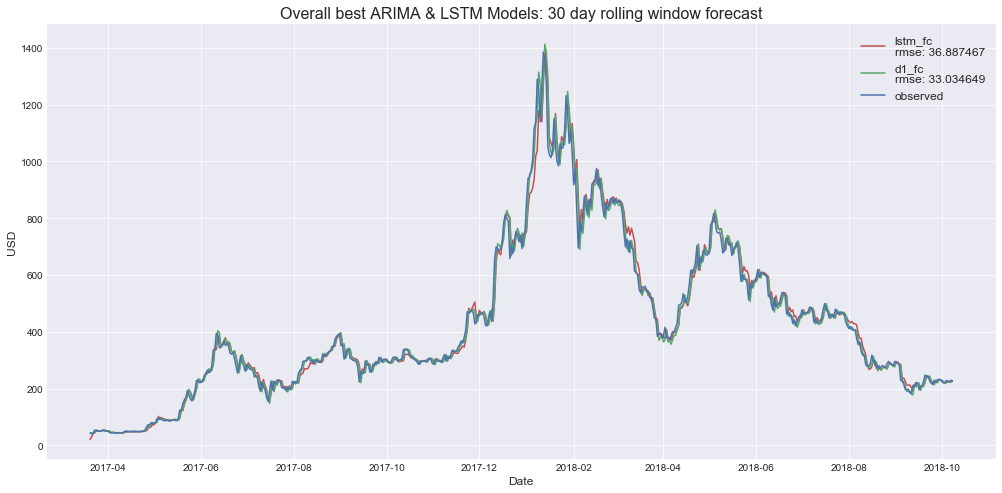

In [212]:
# best overall arima & lstm
best_lstm = adamlr0005

fig, ax = plt.subplots(figsize=figsize1)
# lstm
ax.plot(
    ts.eth_close[-len(best_lstm):].index,
    np.array(best_lstm).reshape(len(best_lstm),),
    label="lstm_fc\nrmse: {:.6f}".format(lstm_rmse(best_lstm)),
    c=colors[2]
)
# arima
ax.plot(
    ts.eth_close[-len(adamlr005):].index,
    d1_fc[0][-len(adamlr005):],
    label="d1_fc\nrmse: {:.6f}".format(rmse(ts.eth_close[window:], d1_fc[0])),
    c=colors[1]
)
# observed
ax.plot(
    ts.eth_close[-len(best_lstm):].index,
    ts.eth_close.values[-len(best_lstm):],
    label="observed",
    c=colors[0]
)

ax.set_title("Overall best ARIMA & LSTM Models: {} day rolling window forecast".format(window), size=title_fontsize)
ax.set_xlabel("Date", size=ax_fontsize)
ax.set_ylabel("USD", size=ax_fontsize)
ax.legend(prop={'size':ax_fontsize})
plt.show()

outline

#### Ethereum Time Series Analysis
1. Introduction
    - Imports:
        - Python: datetime, time, warnings
        - Preprocessing/Viz: numpy, pandas, matplotlib, seaborn, sklearn.preprocessing, ruptures
        - Modeling: statsmodels.tsa.arima_model, tensorflow, keras.models, .layers, .backend
        - Evaluation: statsmodels.tsa.stattools, scipy.stats, sklearn.metrics
    - Description of Research Question/Task
2. Data: TS Only
    - Scrape/APIs/Clean
    - Load/EDA
        - Visualize TS: ADF (Augmented Dickey-Fuller) Unit Root Test
        - Distribution: D'Agostino/Pearson Normality Test
    - Changepoint Analysis
        - PELT (Pruned Exact Linear Time)
    - Feature Engineering: changepoint dummies
3. Modeling/Forecasting
    - ARIMA
        - Stationarity: ADF
        - AR/MA (Auto Regressive/Moving Average): ACF/PACF (Auto/Partial Auto Correlation Functions)
        - Modeling: AIC/BIC (Akaike/Bayesian Information Critera), RMSE (Root Mean Squared Error)
        - Forecasting: Moving window, RMSE
    - Neural Networks
        - MLP ANN (Multi Layer Perceptron Artificial Neural Network): simple, deep, RMSE
        - LSTM RNN (Long Short-Term Memory Recurrent Neural Network): RMSE
    - Visualize/Summarize Results
5. Data: Exogenous Variables
    - Scrape/APIs/Clean
    - Granger Causality
    - Feature Engineering: Collinearity, PCA (Principle Component Analysis), UMAP(?) (Uniform Manifold Approximation and Projection)
6. Modeling/Forecasting
    - ARIMA(X)
    - Neural Networks
        - MLP ANN
        - LSTM RNN
    - Visualize/Summarize Results
7. Overall Summary & Conclusions
8. Deployment